In [2]:
# Packages for data processing 
import numpy as np, pandas as pd, math
#Packages for webpage crawling
import requests as r
import re
from bs4 import BeautifulSoup as BS
#Packages for nature language processing
import spacy,pyinflect
from pyinflect import getAllInflections
#import nltk,string,re,emoji
from collections import Counter
from nltk.corpus import stopwords as sw
from nltk.util import ngrams as ng
from nltk.tokenize import word_tokenize as tk
from nltk.stem import WordNetLemmatizer as wn
import gender_guesser.detector as gen
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import sentiwordnet as swn
#Packages for machine learning (flair and bert_based model)
from flair.models import TextClassifier
from flair.data import Sentence
import tweetnlp
import gensim
#Packages for LDA Visualisation
import pyLDAvis
import pyLDAvis.gensim_models
#Packages for Twitter API and configuration
import tweepy as tw, configparser  
#Packages about time
import time as t, datetime as dt, rfc3339
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
#Packages for visualisation
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Reqest the webpages including the synonymsous words or meanings of these topics: car, buy, and drive
car_url='https://www.thesaurus.com/browse/car'
buy_url='https://www.thesaurus.com/browse/buy'
buying_url='https://www.thesaurus.com/browse/buying'
drive_url='https://www.thesaurus.com/browse/drive'

# Crawling the synonyms of four topics: (car, buy, buying, drive) from Thesurus.com
def keywordExtract(url_name,class_name):
    page_name=r.get(url_name)
    soup_name=BS(page_name.content,'html.parser')
    key_soup=soup_name.find('ul', class_=class_name).find_all('a')
    list_name=[]
    for key in key_soup:
        new_key=key['href'][8:].replace('%20',' ')
        list_name.append(new_key)
    return list_name

# I only captured the red-marked words which contain the most closed meanings as the chosen topics
car_sym=keywordExtract(car_url,'css-1xohnkh e1ccqdb60')[:14]
car_sym.insert(0,'car')
buy_sym=keywordExtract(buy_url,'css-wmtunb e1ccqdb60')[:4]
buy_sym.insert(0,'buy')
buying_sym=keywordExtract(buying_url,'css-1lj4erq e1ccqdb60')[:3]
buying_sym.insert(0,'buying')
buy_sym=buy_sym+buying_sym
drive_sym=keywordExtract(drive_url,'css-n85ndd e1ccqdb60')[:4]
drive_sym.insert(0,'drive')

# Altough I have got thirty words as required keywords for tweet requests, it is recommended to include different tenses or forms of words 
#, as many Twitter users will use them depending on different contents.
nlp = spacy.load('en_core_web_sm')

buy_str=' '.join(buy_sym)
buy_doc=nlp(buy_str)
buy_extension_list=[]
for num in range(len(buy_doc)):
    token = buy_doc[num]
    if token.tag_ in ['NN','VB','VBG']:
        buy_extension_list.append(token._.inflect('VB',inflect_oov=True))
buy_extension_list=[ele for ele in list(set(buy_extension_list+['invest','shop','transact'])) if ele]

def extension(sym):
    sym_str=' '.join(sym)
    sym_token=nlp(sym_str)
    extension_list=[]
    for num in range(len(sym_token)):
        token = sym_token[num]
        if token.tag_ in ['NN','VB','VBG']:
            if str(token)!=token._.inflect('VBD',inflect_oov=True)[:len(token)]:
                extension_list.append(token._.inflect('VBD',inflect_oov=True))              
            if str(token)!=token._.inflect('VBG',inflect_oov=True)[:len(token)]:
                 extension_list.append(token._.inflect('VBG',inflect_oov=True))
            if str(token)!=token._.inflect('VBN',inflect_oov=True)[:len(token)]:
                 extension_list.append(token._.inflect('VBN',inflect_oov=True))
            if str(token)!=token._.inflect('VBZ',inflect_oov=True)[:len(token)]:
                 extension_list.append(token._.inflect('VBZ',inflect_oov=True))
    return extension_list

buy_sym=list(set(extension(buy_extension_list)+buy_extension_list))
buy_sym.append('acquisition')

drive_sym=list(set(extension(drive_sym)+drive_sym))

# According to car registration records of the UK from 2019 to 2022, the top 10 sales brands were selected as they might be mentioned more frequently than the other brands when talking about automative topics
brand_list=['Ford','BMW','Volkswagen','Mercedes-Benz','Audi','Vauxhall','Toyota','Kia','Hyundai','Land Rover']

#While searching for Google Trends data, various spellings or expressions that a user could use while posting about a car model were checked.
brand_abb=['VW','Mercedes','Voho','Landy','Bimmer','MBZ']

# The most popular Car sale Models in the UK, as a same replacement of the brand name: One model for one brand
brand_model=['fiesta','corolla','Series','polo','sportage','tucson','corsa','A-Class','discovery','A3']

# Name of car types when people are talking a series of car
car_type=['coupe','hatchback','sedan','sports','suv']

# Names of many important parts of car are also added in as I found that is a part of comments when people value their cars:15 most important words from https://www.collinsdictionary.com/word-lists/car-parts-of-a-car
car_tool=['grip','bumper','tyre','brake','bonnet','airbag','carburettor','piston','engine','battery','fuel tank','hood','steering wheel','accelerator','seatbelt']
#But there isn't such words like automobiling/automobiled or jeeping/jeeped, so it has to be deleted
car_sym.remove('ride')
car_sym.append('vehicle')

def dfGenerator(name,list):
    return pd.DataFrame({name:list})
#Put all the words into a dataframe sorted by different segements.
keywords=pd.concat([dfGenerator('Car',car_sym),
                    dfGenerator('Buy',buy_sym),
                    dfGenerator('Drive',drive_sym),
                    dfGenerator('Brand',brand_list),
                    dfGenerator('Brand Abbreviation',brand_abb),
                    dfGenerator('Brand Model',brand_model), 
                    dfGenerator('Car Tool',car_tool),
                    dfGenerator('Car Type',car_type)],
                    axis=1)
print(keywords)

# To limit the search zone that has to contain the elements of car, purchase, drive 
keylist_of_car=car_sym+brand_list+brand_abb+brand_model+car_tool+car_type
keylist_of_buy=buy_sym
keylist_of_drive=drive_sym

#Build the content of query: element 'car' is compulsory which the other elements are optional
query_content='('+' '.join(keylist_of_car).replace(' ',' OR ')+') ('+' '.join(keylist_of_buy+keylist_of_drive).replace(' ',' OR ')+') lang:en place_country:GB -is:nullcast -has:links'
print(len(query_content), query_content)
# Build and read the config for password safety
config=configparser.RawConfigParser()
config.read('config.ini')

api_key=config['twitter']['api_key']
api_key_secret=config['twitter']['api_key_secret']
access_token=config['twitter']['access_token']
access_token_secret=config['twitter']['access_token_secret']
bearer_token=config['twitter']['bearer_token']

# Authtication of my Twitter api
client = tw.Client(bearer_token,api_key, api_key_secret,access_token, access_token_secret,wait_on_rate_limit=True)

# Building the timestrap of each hour
def dateRange(start_date, end_date):
    while start_date <= end_date:
        yield start_date
        start_date+=dt.timedelta(hours=8)

# Set the starting at the first hour of Feburary 1st 2019 and the end time at the same hour of October 1st 2021
start_date_1_1 = datetime(2019, 2, 1, 0, 00,00)
end_date_1_1 = datetime(2019, 4, 1, 0, 00,00)
start_date_1_2 = datetime(2019, 8, 1, 0, 00,00)
end_date_1_2 = datetime(2019, 10, 1, 0, 00,00)

start_date_2_1 = datetime(2020, 2, 1, 0, 00,00)
end_date_2_1 = datetime(2020, 4, 1, 0, 00,00)
start_date_2_2 = datetime(2020, 8, 1, 0, 00,00)
end_date_2_2 = datetime(2020, 10, 1, 0, 00,00)

start_date_3_1 = datetime(2021, 2, 1, 0, 00,00)
end_date_3_1 = datetime(2021, 4, 1, 0, 00,00)
start_date_3_2 = datetime(2021, 8, 1, 0, 00,00)
end_date_3_2 = datetime(2021, 10, 1, 0, 00,00)

# remember to change about the time

def time_builder(start_date,end_date):
    time=[]
    for single_date in dateRange(start_date, end_date):
        time.append(single_date.strftime('%Y-%m-%d %H:%M:%S'))
    return time

first_time_1=time_builder(start_date_1_1,end_date_1_1)[:-1]+time_builder(start_date_1_2,end_date_1_2)[:-1]
second_time_1=time_builder(start_date_1_1,end_date_1_1)[1:]+time_builder(start_date_1_2,end_date_1_2)[1:]

first_time_2=time_builder(start_date_2_1,end_date_2_1)[:-1]+time_builder(start_date_2_2,end_date_2_2)[:-1]
second_time_2=time_builder(start_date_2_1,end_date_2_1)[1:]+time_builder(start_date_2_2,end_date_2_2)[1:]

first_time_3=time_builder(start_date_3_1,end_date_3_1)[:-1]+time_builder(start_date_3_2,end_date_3_2)[:-1]
second_time_3=time_builder(start_date_3_1,end_date_3_1)[1:]+time_builder(start_date_3_2,end_date_3_2)[1:]

def rfcTimeConvetor(time_list):
    new_time_list=[]
    for single_record in time_list:
        datetime_object = datetime.strptime(single_record, '%Y-%m-%d %H:%M:%S')
        rfc_records=rfc3339.rfc3339(datetime_object)
        new_time_list.append(rfc_records)
    return new_time_list

rfc_first_time=rfcTimeConvetor(first_time_1)+rfcTimeConvetor(first_time_2)+rfcTimeConvetor(first_time_3)
rfc_second_time=rfcTimeConvetor(second_time_1)+rfcTimeConvetor(second_time_2)+rfcTimeConvetor(second_time_3)

              Car          Buy    Drive          Brand Brand Abbreviation  \
0             car      acquire    drive           Ford                 VW   
1            auto     purchase      run            BMW           Mercedes   
2      automobile       bought     rode     Volkswagen               Voho   
3             bus   purchasing  driving  Mercedes-Benz              Landy   
4     convertible      bargain     tour           Audi             Bimmer   
5            jeep    acquiring     trip       Vauxhall                MBZ   
6       limousine          buy    drove         Toyota                NaN   
7         machine         shop     ride            Kia                NaN   
8           motor     transact   ridden        Hyundai                NaN   
9          pickup       invest   riding     Land Rover                NaN   
10  station wagon  acquisition      NaN            NaN                NaN   
11          truck          NaN      NaN            NaN                NaN   

In [ ]:
# Retrieve all the required data from Twitter API from each eight hours per day of three years
for start_time, end_time in zip(rfc_first_time,rfc_second_time):
    tweet_info_small_list=[]
    tweets=client.search_all_tweets(
                            query_content,                            
                            end_time=end_time,       
                            start_time=start_time,
                            tweet_fields = ['created_at', 'text', 'lang'],
                            user_fields = ['name', 'username', 'location'],
                            sort_order=['relevancy'],
                            expansions='author_id',
                            max_results=100)
    for tweet,user in zip(tweets.data,tweets.includes['users']):
        tweet_info = {
        'created_at': tweet.created_at,
        'text': tweet.text,
        'source': tweet.source,
        'name': user.name,
        'username': user.username,
        'location': user.location}
        tweet_info_small_list.append(tweet_info)
    tweets_datasource = pd.DataFrame(tweet_info_small_list)
    tweets_datasource.to_csv('TwData_300.csv',sep=',', mode='a',encoding='utf_8')

In [ ]:
#Get rid of the empty lines and sort all the data by the time it happened
raw_data=pd.read_csv('C:/Users/ky002/Desktop/Dickens/Postgraduate/Dissertation/Data Source/Data Source/TwData_300.csv',sep=',',header=0,encoding='utf_8')
raw_data=raw_data.drop(columns=['Unnamed: 0','source'])
raw_data=raw_data[raw_data['text']!='text'].sort_values(by='created at').reset_index(drop=True)

def treatmentMarker(row):
    processed_time=datetime.strptime(row['created at'][:17],'%Y%m%d %H:%M:%S')
    if processed_time<datetime.strptime('20191001 00:00:00','%Y%m%d %H:%M:%S'):
        answer='before covid'
    else:
        answer='after covid'
    return answer
raw_data['treatment/control']=raw_data.apply(treatmentMarker,axis=1)

#Remove all the emoji used in the text
def emojiFreeText(text):
    pattern = re.compile(pattern = '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FC'  # transport & map symbols
        u'\U0001F1E6-\U0001F1FF'  # flags (iOS)
        u'\U00002500-\U00002BEF'  # chinese char
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        u'\U0001f926-\U0001f937'
        u'\U00010000-\U0010ffff'
        u'\u2640-\u2642'
        u'\u2600-\u2B55'
        u'\u23cf'
        u'\u23e9'
        u'\u231a'
        u'\u3030'
        u'\ufe0f'
        u'\u200a-\u200f'
        ']+', 
        flags = re.UNICODE)
    return pattern.sub(r'',text)
    
#Remove all the puntutation and number used in the text
def puntuationFreeText(text):
    tab=str.maketrans(dict.fromkeys(string.punctuation))
    pure_text=text.translate(tab)
    pure_text=''.join([let for let in pure_text if not let.isdigit()])
    return pure_text

def removeMeaninglessName(text):
    exclude_words_of_name=sw.words('english')
    new_name=[]
    for word in text.split():
        if word not in exclude_words_of_name:
            new_name.append(word)
    return ' '.join(new_name)

# Remove all the space used at the start of sentence, lower the case, and only need the first name of users
def removeSpace(text):
    if len(text)==0:
        text='unknown'
    else:
        if text[0]==' ':
            text=text.lower()[1:]
        else:
            text=text.lower()
    return text

def removeAlpha(text):
    for word in text.split():
        if len(word)>1:
            pattern=re.compile(word)
            poistion=[match.start() for match in pattern.finditer(text)][0]
            text=text[poistion:]
            break
    return text

gender=['unknown']*len(raw_data.name)
fitered_name_list=[]
gender_list=[]

for nam,sex,username in zip(raw_data.name,gender,raw_data.username):
    name=removeAlpha(removeSpace(removeMeaninglessName(puntuationFreeText(emojiFreeText(nam)))))
    if (name[0:3]=='sir'and len(name.split()[0])==3):
        name=name[4:]
        sex='male'
    elif (name[0:2]=='mr'and len(name.split()[0])==2):
        name=name[3:]
        sex='male'
    elif (name[0:2]=='dr'and len(name.split()[0])==2):
        name=name[3:]
        sex='male'
    elif (name[0:4]=='prof' and len(name.split()[0])==4):
        name=name[5:]
        sex='male'
    elif (name[0:4]=='miss' and len(name.split()[0])==4):
        name=name[5:]
        sex='female'
    elif (name[0:5]=='madam'and len(name.split()[0])==5):
        name=name[6:]
        sex='female'
    elif (name[0:4]=='lady'and len(name.split()[0])==4):
        name=name[5:]
        sex='female'
    elif (name[0:2]=='ms'and len(name.split()[0])==2):
        name=name[3:]
        sex='female'
    elif (name[0:3]=='mrs'and len(name.split()[0])==3):
        name=name[4:]
        sex='female'
    elif (name[0:5]=='nurse'):
        name=name[6:]
        sex='female'
    elif (name[0:2]=='mx'and len(name.split()[0])==2):
       name=name[3:]
       sex='unknown'
    if len(name.split())==0:
        name='unknown'
    else:
        first_name = ''.join([word for word in name.split()[0] if word!='unknown'])
        first_name =''.join([word[0].upper() + word[1:] for word in first_name.split()])
        if len(re.findall('([A-Z][a-z]+)', first_name))!=0:
            first_name=re.findall('([A-Z][a-z]+)', first_name)[0]
        else:
            first_name=removeAlpha(removeSpace(puntuationFreeText(username)))
            first_name =''.join([word[0].upper() + word[1:] for word in first_name.split()])
            first_name=re.findall('([A-Z][a-z]+)', first_name)[0]
            if len(first_name)<=2 or len(first_name)>10:
                first_name=max(first_name.split(), key=len)
    if len(first_name)>10:
        origin_name=removeAlpha(removeMeaninglessName(puntuationFreeText(emojiFreeText(nam))))
        if len(re.findall('([A-Z][a-z]+)', origin_name))!=0:
            first_name=re.findall('([A-Z][a-z]+)', origin_name)[0]
    fitered_name_list.append(first_name)
    gender_list.append(sex)

raw_data['first name']=pd.DataFrame(fitered_name_list)
raw_data['gender']=pd.DataFrame(gender_list)
known_name=raw_data['first name'].loc[raw_data['gender'] =='unknown']
detector=gen.Detector()
raw_data['predicted gender']=raw_data['first name'].apply(lambda a: detector.get_gender(a))
raw_data['gender'].loc[(raw_data['gender']=='unknown')] = raw_data['predicted gender']

raw_data.loc[(raw_data['gender']=='mostly_female'),'gender']='female'
raw_data.loc[(raw_data['gender']=='mostly_male'),'gender']='male'
raw_data.loc[(raw_data['gender']=='andy'),'gender']='unknown'
raw_data=raw_data.drop(columns=['predicted gender'])

#Assume the people who live in the city have better purchasing power than people who live outside the city
london=['london']
southeast=['oxford','portsmouth','southampton','reading','brighton','milton keynes','slough','southend-on-sea','luton']
southwest=['bath','bristol','plymouth','gloucester','bournemouth','poole']
northwest=['manchester','liverpool','lancaster','warrington','bolton','blackpool']
northeast=['newcastle','durham','sunderland']
yorkshire=['york','leeds','bradford','kingston','sheffield','huddersfield','middlesbrough']
west_midland=['birmingham','coventry','stoke-on-trent','wolverhampton','swindon','wolverhampton','telford']
east_midland=['derby','nottingham','leicester','northampton','cambridge','peterborough']
scotland=['edinburgh','glasgow','aberdeen','dundee']
wales=['cardiff','swansea']
northern_ireland=['belfast']
new_location=[]
for location in raw_data.location:
    if type(location)==float:
        location='unknown'
    else:
        location=location.split(',')[0].lower()
    if location=='uk' or location=='united kingdom':
        location='unknown'
    elif any(city in location for city in london):
        location='london'
    elif any(city in location for city in southeast):
        location='southeast'
    elif any(city in location for city in southwest):
        location='southwest'
    elif any(city in location for city in northwest):
        location='northwest'
    elif any(city in location for city in northeast):
        location='northeast'
    elif any(city in location for city in west_midland):
        location='west midland'
    elif any(city in location for city in east_midland):
        location='east midland'
    elif any(city in location for city in yorkshire):
        location='yorkshire'
    elif any(city in location for city in scotland):
        location='scotland'
    elif any(city in location for city in wales):
        location='wales'
    elif any(city in location for city in northern_ireland):
        location='northern ireland'
    else:
        location='other towns and places'
    new_location.append(location)
raw_data.insert(loc=5, column='new_location', value=new_location)
    
#Remove all the contact signs and people names mentioned inside the text
# Too many emoji with the same content but I can't remove them and they will pollute the word source
def deleteRepetition(emoji_content, max_times=2):
    emoji=list(emoji_content)
    emotion=' '.join(emoji_content)
    checklist = [lab for lab in dict.fromkeys(emoji) if emoji.count(lab) > 1]
    for i in range(len(checklist)):
       while(emoji.count(checklist[i]) > max_times):
           emoji.remove(checklist[i])
           emotion=''.join(emoji)
    return emotion

def removeDuplicateEmoji(text):
    pure_text=emojiFreeText(text)
    duplicate_emoji = []
    for emo in text:
        if emo in (emoji.UNICODE_EMOJI['en'] or emoji.UNICODE_EMOJI['es'] or emoji.UNICODE_EMOJI['pt'] or emoji.UNICODE_EMOJI['it']):
            duplicate_emoji.append(emo)
    twice_maximum=deleteRepetition(duplicate_emoji)
    text=pure_text+twice_maximum
    return text

def freeContact(text):
    pattern = re.compile('@+')
    if len(re.findall(pattern,text))!=0:
        pattern = re.compile('@+')
        times=len([match.span() for match in pattern.finditer(text)])
        time=0
        while time<times:
            poistion=[match.start() for match in pattern.finditer(text)][0]
            text=text[:poistion]+text[poistion+len(text[poistion:].split()[0]):]
            text=text.replace('  ', ' ')
            time+=1
        else:
            text=text
    return text

#Restore all emoji into readable meanings
def emojiLemon(text):
    return emoji.demojize(text, delimiters=('', ' ')) 

def singleQuoteTransfer(text):
    text=re.sub('  ',' ',text)
    text=re.sub("'ve",' have',text)
    text=re.sub("'d",' would like to',text)
    text=re.sub("n't",' not',text)
    text=re.sub("'m",' am',text)
    text=re.sub("'s",' is',text)
    text=re.sub('_',' ',text)
    text=re.sub('hrs','hours', text)
    text=re.sub('pls','please', text)
    text=re.sub('bf','boyfriend',text)
    text=re.sub('dcpc','driver certificate of professional competence', text)
    text=re.sub('celebs','celebrities', text)
    return text

#remove all the tags used in sentences
def removeTag (text):
    text=' '.join([letter for letter in text.split() if not len(letter)>=15])
    text=text.lower()
    text=re.sub('n not',' not',text)
    text=re.sub('ca not','can not',text)
    return text

#remove all punctuation used in sentences
def removePunc(text):
    text = re.sub(r'''\W+\s*''',' ',text,flags=re.VERBOSE)
    text=''.join([let for let in text if not let.isdigit()])
    return text

#remove all two-letter words and some meaningless abbreviations in sentences
def meaninglessWordRemove(text):
    new_sw=sw.words('english')
    new_sw=list(set(new_sw+list(string.ascii_lowercase)))+['much','many','lol','etc','yeah','ummm','haha','omg','hmmm']
    new_sw.remove('not')
    new_text=[]
    for word in text.split():
        if len(word)>2:
            new_text.append(word)
    text=' '.join([word for word in new_text if word not in new_sw])
    return text

def sentenceLemon(text):
        lemon = wn()
        each_lemmon_str = ' '.join([lemon.lemmatize(word) for word in tk(text)])
        allow_postags = set(['NOUN', 'VERB', 'ADJ', 'ADV', 'PROPN'])
        words = []
        for token in nlp(each_lemmon_str):
            if token.pos_ in allow_postags:
                words.append(token.lemma_)
        return ' '.join(words)

def abbrChange(text):
    cos='cos'
    bcos='bcos'
    rd='rd'
    mon='mon'
    tue='tues'
    wed='wed'
    thu='thu'
    fri='fri'
    sat='sat'
    tfl='tfl'
    amp='amp'
    text=re.compile(r'\b%s\b' % cos, re.I).sub('because',text)
    text=re.compile(r'\b%s\b' % bcos, re.I).sub('because',text)
    text=re.compile(r'\b%s\b' % rd, re.I).sub('road',text)
    text=re.compile(r'\b%s\b' % mon, re.I).sub('monday',text)
    text=re.compile(r'\b%s\b' % tue, re.I).sub('tuesday',text)
    text=re.compile(r'\b%s\b' % wed, re.I).sub('wednesday',text)
    text=re.compile(r'\b%s\b' % thu, re.I).sub('thursday',text)
    text=re.compile(r'\b%s\b' % fri, re.I).sub('friday',text)
    text=re.compile(r'\b%s\b' % sat, re.I).sub('saturday',text)
    text=re.compile(r'\b%s\b' % tfl, re.I).sub('transport london',text)
    text=re.compile(r'\b%s\b' % amp, re.I).sub('amplifier',text) 
    return text

# Process the original text by sequence of functions
def dataProcessingAuto(text):
    processed_text=sentenceLemon(
        abbrChange(
            meaninglessWordRemove(
                removeTag(
                    removePunc(
                        singleQuoteTransfer(
                            emojiLemon(
                                freeContact(
                                    removeDuplicateEmoji(text)))))))))
    return processed_text

raw_data['new_processed_text']=raw_data['text'].apply(dataProcessingAuto)
print('The capacity of the dataset is:',len(raw_data))

def dataProcessingAutoEmojiFree(text):
    processed_text=sentenceLemon(
        abbrChange(
            meaninglessWordRemove(
                removeTag(
                    removePunc(
                        singleQuoteTransfer(
                            emojiLemon(
                                freeContact(
                                    emojiFreeText(text)))))))))
    return processed_text
raw_data['emoji_processed_text']=raw_data['text'].apply(dataProcessingAutoEmojiFree)

['buy new car', 'get car drive', 'mile round trip', 'ice cream van', 'car drive home', 'rear wheel drive', 'open top bus', 'panic buy fuel', 'drive car park', 'brother tony kill', 'buy electric car', 'pass driving test', 'get back car', 'car hit walk', 'park amplifier ride', 'use public transport', 'red ride hood', 'self drive car', 'bus driver drive', 'buy brand new', 'top bus tour', 'brand new car', 'get new car', 'hire car drive', 'drive bus lane', 'wrong side road', 'people panic buy', 'buy second hand', 'drive new car', 'car park drive', 'buy first car', 'get run bus', 'bus ride home', 'car boot sale', 'red riding hood', 'buy use car', 'bus ride away', 'walk home night', 'front wheel drive', 'drive electric car', 'drive petrol station', 'auto body paint', 'body paint shop', 'driving consider follow', 'second hand car', 'drive wrong way', 'test drive car', 'drink driving consider', 'pay road tax', 'drive home work']
similarity ratio_1_2 : 0.5
similar words_2_3 : ['drive bus', 'buy 

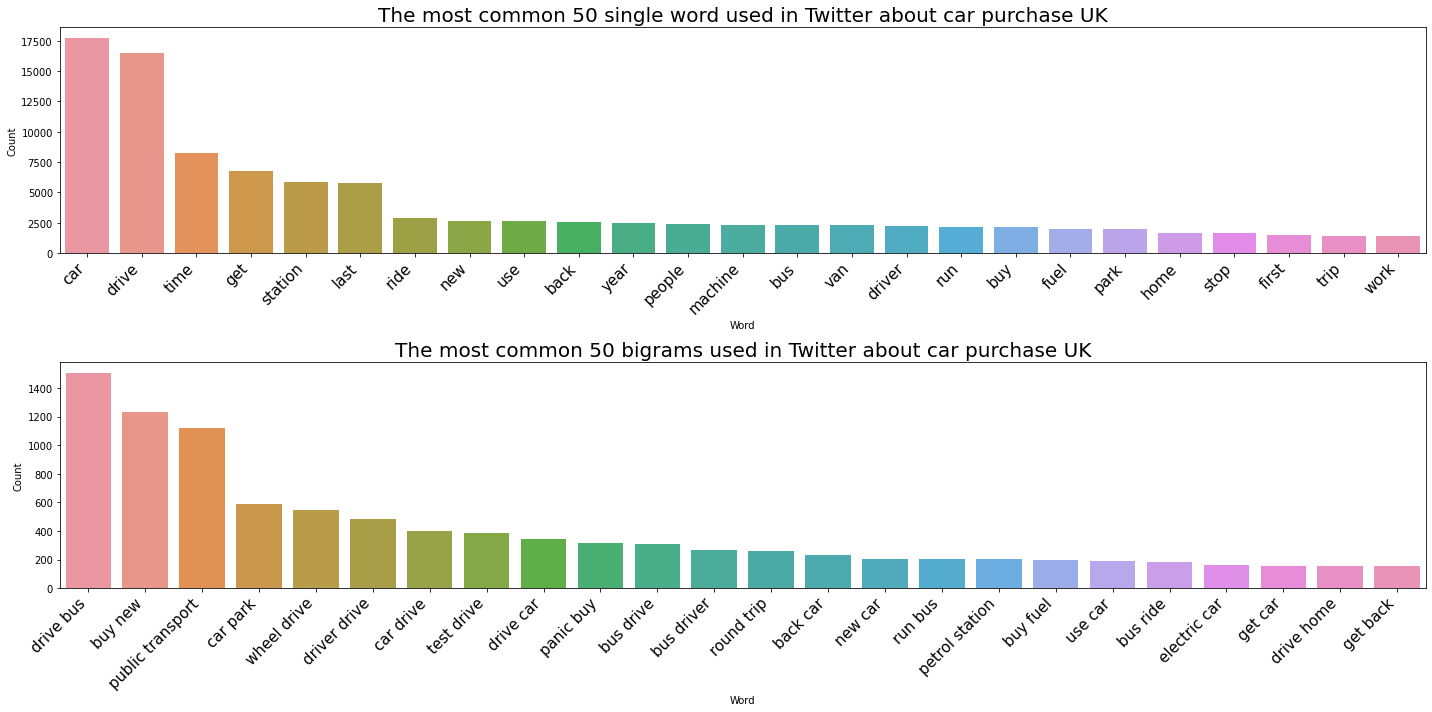

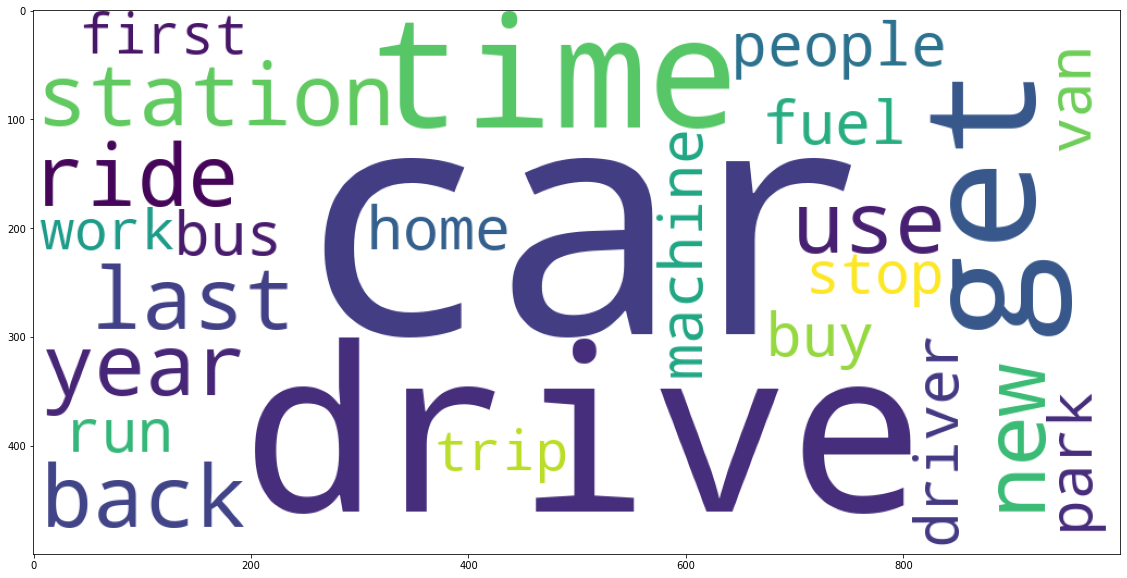

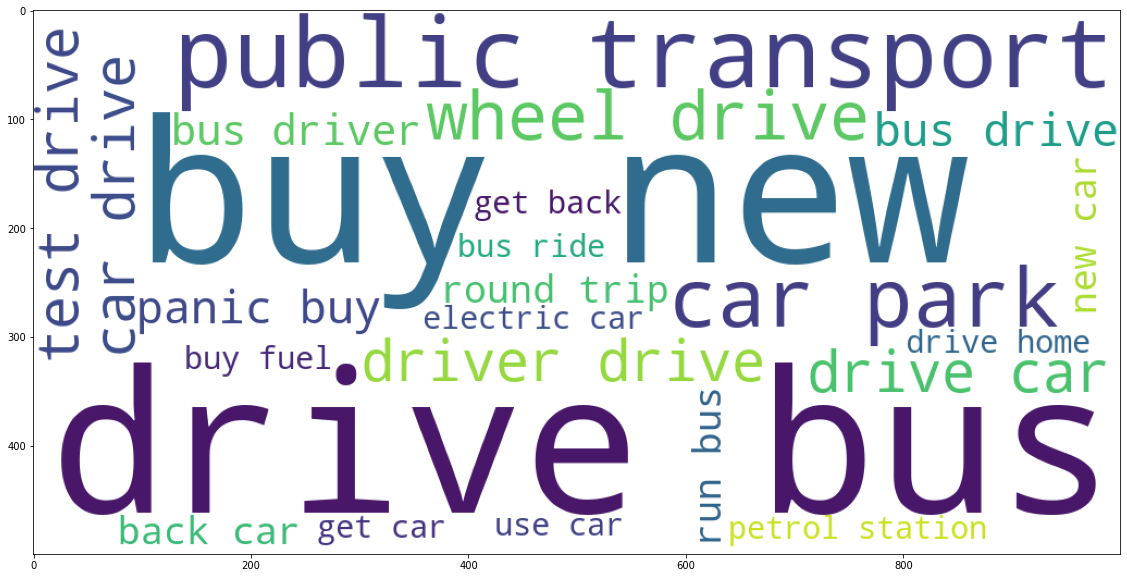

In [8]:
#Get all tweets for word frequency check
all_processed_tweets=' '.join([tweets for tweets in raw_data['emoji_processed_text']])

# Extract the most frequent word chunk
def extractNearestWords(data, dim):
    n_grams = ng(tk(data), dim)
    return [ ' '.join(grams) for grams in n_grams]

# Count the the top 50 most frequent words in one word, two, and three word chunks
fifty_one_word = Counter(all_processed_tweets.split()).most_common(50)
fifty_two_word=Counter(extractNearestWords(all_processed_tweets,2)).most_common(50)
fifty_three_word=Counter(extractNearestWords(all_processed_tweets,3)).most_common(50)

def wordAndCount(one_word):
    one_word_list=[]
    one_word_list_count=[]
    for key in one_word:
      one_word_list.append(key[0])
      one_word_list_count.append(key[1])
    return one_word_list,one_word_list_count

one_word,one_word_count=wordAndCount(fifty_one_word)
two_word,two_word_count=wordAndCount(fifty_two_word)
three_word,three_word_count=wordAndCount(fifty_three_word)
print(three_word)

similar_words_1_2=list(set([word for word in one_word if word in ' '.join([one for one in two_word]).split()]))
print('similarity ratio_1_2 :', len(similar_words_1_2)/len(two_word))

similar_words_2_3=[]
for word in two_word:
    for words in three_word:
        if word in words:
            similar_words_2_3.append(word)
similar_words_2_3=list(set(similar_words_2_3))
print('similar words_2_3 :', similar_words_2_3)
print('similarity ratio_2_3 :', len(similar_words_2_3)/len(three_word))

def similarWordCount(similar_words,one_word):
    value=[]
    for word in similar_words:
        for key in one_word:
            if word==key[0]:
                value.append(key[1])
    return value

similar_words_1_2_count=similarWordCount(similar_words_1_2,fifty_one_word)
similar_words_2_3_count=similarWordCount(similar_words_2_3,fifty_two_word)

df_similar_words_1_2=pd.DataFrame({'Word':similar_words_1_2,'Count':similar_words_1_2_count})
df_similar_words_2_3=pd.DataFrame({'Word':similar_words_2_3,'Count':similar_words_2_3_count})

#Visualization for single and dural word chunk
fig, axes = plt.subplots(2,1, figsize=(20,10))

sns.barplot(x ='Word', y ='Count', data=df_similar_words_1_2,order=df_similar_words_1_2.sort_values('Count',ascending = False).Word,ax=axes[0])
axes[0].set_xticklabels(similar_words_1_2,rotation=45, ha='right',fontsize=15)
axes[0].set_title('The most common 50 single word used in Twitter about car purchase UK', fontsize=20)
sns.barplot(x ='Word', y ='Count', data=df_similar_words_2_3,order=df_similar_words_2_3.sort_values('Count',ascending = False).Word,ax=axes[1])
axes[1].set_xticklabels(similar_words_2_3,rotation=45, ha='right',fontsize=15)
axes[1].set_title('The most common 50 bigrams used in Twitter about car purchase UK', fontsize=20)
plt.tight_layout()
plt.show()

sw1='similar_words_1_2'
sw2='similar_words_2_3'

#word-cloud for twitter
def wordCloudGenerator(similar_word,sw):
    plt.figure(figsize = (45,10))
    word_could_dict=Counter(similar_word)
    wordcloud = WordCloud(background_color='white',width = 1000, height = 500).generate_from_frequencies(word_could_dict)
    plt.savefig(sw+'.png')
    plt.imshow(wordcloud)

wordCloudGenerator(similar_words_1_2,sw1)
wordCloudGenerator(similar_words_2_3,sw2)

In [24]:
# Combination of lexicon-based models for sentimental analysis
#Build a mapping system that transfers all numbers to the size of [-1,1]
scaler = MinMaxScaler(feature_range=(-1, 1))

def textBlobSentimentAnalysis(sentiment_text):
    blob_attitude = TextBlob(sentiment_text).sentiment.polarity
    return blob_attitude

blob_attitude_list=[]    
for text in raw_data['new_processed_text']:
    blob_attitude=textBlobSentimentAnalysis(text)
    blob_attitude_list.append(blob_attitude)
blob_attitude_score=np.array(blob_attitude_list).reshape(-1,1)

textblob_result=scaler.fit_transform(blob_attitude_score).flatten()

def vaderSentimentAnalysis(sentiment_text):
    score=SentimentIntensityAnalyzer().polarity_scores(sentiment_text)
    vader_pos=score['pos']
    vader_neg=score['neg']
    return vader_pos-vader_neg

vader_attitude_list=[]
for text in raw_data['new_processed_text']:
    vader_attitude=vaderSentimentAnalysis(text)
    vader_attitude_list.append(vader_attitude)
vader_attitude_score=np.array(vader_attitude_list).reshape(-1,1)
vader_result=scaler.fit_transform(vader_attitude_score).flatten()

def sentiwordnetAnalysis(sentiment_text):
    posit=[]
    negat=[]
    length_of_sentence=len(sentiment_text)
    range_of_sentence=range(length_of_sentence)
    for word in sentiment_text.split(): 
        each_sentence = swn.senti_synsets(word)
        each_sentence_list=list(each_sentence)
        if len(each_sentence_list)!=0:
            pos=each_sentence_list[0].pos_score()
            neg=each_sentence_list[0].neg_score()
            posit.append(pos)
            negat.append(neg)
        else:
            pos=0
            neg=0
            posit.append(pos)
            negat.append(neg)
    pos=sum(posit)/length_of_sentence
    neg=math.exp(sum(negat)/length_of_sentence)-1
    return pos-neg

sentiwordnet_attitude_list=[]
for text in raw_data['new_processed_text']:
    sentiwordnet_attitude=sentiwordnetAnalysis(text)
    sentiwordnet_attitude_list.append(sentiwordnet_attitude)
sentiwordnet_attitude_score=np.array(sentiwordnet_attitude_list).reshape(-1,1)
sentiwordnet_result=scaler.fit_transform(sentiwordnet_attitude_score).flatten()

def lexiconBasedaAnalysis():
    full_result=textblob_result+vader_result+sentiwordnet_result
    attitude_list=[]
    attitude=None
    for each_result in full_result:
        if each_result<-0.50:
           attitude='Extremely Negative'
        elif each_result>=-0.50 and each_result<-0.05:
            attitude='Slightly Negative'
        elif abs(each_result)<=0.05:
            attitude='Neutral'
        elif each_result>0.05 and each_result<=0.50:
            attitude='Slightly Positive'
        else:
            attitude='Extremely Positive'
        attitude_list.append(attitude)
    return attitude_list

raw_data.insert(loc=10, column='lexicon_based_sentiment', value=lexiconBasedaAnalysis())

In [ ]:
scaler = MinMaxScaler(feature_range=(-1, 1))
flair_score=[]
def flairSentimentAnalysis(sentiment_text):
    classifier = TextClassifier.load('sentiment-fast')
    sentence = Sentence(sentiment_text)
    classifier.predict(sentence)
    attitude=sentence.labels[0].value
    score=sentence.labels[0].score
    if attitude=='NEGATIVE':
        score=-score
    return score

for text in raw_data['new_processed_text']:
    score=flairSentimentAnalysis(text)
    flair_score.append(score)
flair_attitude_score=np.array(flair_score).reshape(-1,1)
flair_result=scaler.fit_transform(flair_attitude_score).flatten()

# RoBERTa model Sentiment analysis
# Loading pre-trained RoBERTa model
model = tweetnlp.load('sentiment') 
sentence=model.predict(raw_data_text,batch_size=4096)
roberta_score=[]
for each in sentence:
    attitude=each['label']
    score=each['probability']
    if attitude=='neutral':
        score=0
    elif attitude=='negative':
        score=-score
    roberta_score.append(score)
roberta_attitude_score=np.array(roberta_score).reshape(-1,1)
roberta_result=scaler.fit_transform(roberta_attitude_score).flatten()

def balancer():
    balance=[]
    attitude_list=[]
    attitude=None
    for flair,roberta in zip(flair_result,roberta_result):
            final_result=0.3*flair+0.7*roberta
            balance.append(final_result)
    for score in balance:
        if score<-0.50:
           attitude='Extremely Negative'
        elif score>=-0.50 and score<-0.05:
            attitude='Slightly Negative'
        elif abs(score)<=0.05:
            attitude='Neutral'
        elif score>0.05 and score<=0.50:
            attitude='Slightly Positive'
        else:
            attitude='Extremely Positive'
        attitude_list.append(attitude)
    return attitude_list
raw_data.insert(loc=11, column='bert_based_sentiment', value=balancer())

Counter({'Slightly Negative': 13022, 'Slightly Positive': 8167, 'Extremely Negative': 7388, 'Extremely Positive': 4714, 'Neutral': 2532}) Counter({'Extremely Negative': 13855, 'Slightly Positive': 9209, 'Slightly Negative': 6422, 'Extremely Positive': 5753, 'Neutral': 584})


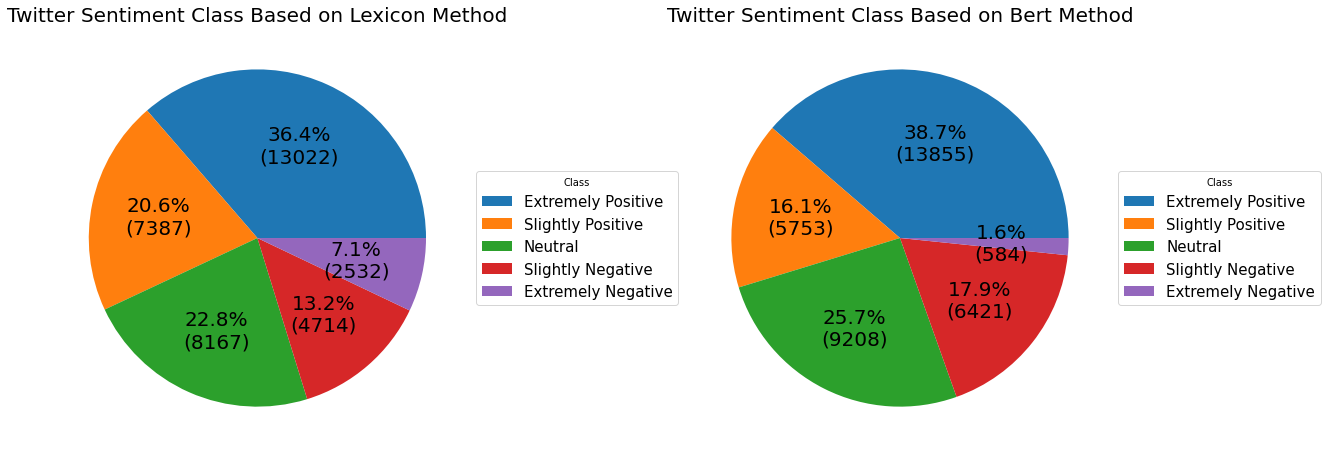

In [53]:
#Sentiment analysis visualization
print(Counter(raw_data['lexicon_based_sentiment']),Counter(raw_data['bert_based_sentiment']))
lexicon_count=list(Counter(raw_data['lexicon_based_sentiment']).values())
bert_count=list(Counter(raw_data['bert_based_sentiment']).values())
#Sentiment analysis visualization
def piechart(picture, all_value):
    absolute = int(np.round(picture/100.*np.sum(all_value),decimals=4))
    return '{:.1f}%\n({:d})'.format(picture, absolute)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(18, 18))

label = ['Extremely Positive','Slightly Positive','Neutral','Slightly Negative','Extremely Negative']

wedges, texts, autotexts = ax1.pie(lexicon_count, autopct=lambda picture: piechart(picture, lexicon_count), textprops={'fontsize': 20})
ax1.legend(wedges, label,
          title='Class',
          loc='center left',
          bbox_to_anchor=(1, 0, 0.5, 1),fontsize=15)
ax1.set_title('Twitter Sentiment Class Based on Lexicon Method', fontsize=20)

wedges, texts, autotexts = ax2.pie(bert_count, autopct=lambda picture: piechart(picture, bert_count), textprops={'fontsize': 20})
ax2.legend(wedges, label,
          title='Class',
          loc='center left',
          bbox_to_anchor=(1, 0, 0.5, 1),fontsize=15)

ax2.set_title('Twitter Sentiment Class Based on Bert Method', fontsize=20)

plt.tight_layout()
plt.show()

In [25]:
#Create dictionary and corpus through gram-making techniques
raw_data_text=[text for text in raw_data['new_processed_text']]
def gensimWord(whole_text):
  new_text = []
  for text in whole_text:
    new_text.append(gensim.utils.simple_preprocess(text, deacc=True))
  return new_text
raw_text = list(gensimWord(raw_data_text))

bigram_phrase=gensim.models.Phrases(raw_text, min_count=3, threshold=200,connector_words=gensim.models.phrases.ENGLISH_CONNECTOR_WORDS)
trigram_phrase=gensim.models.Phrases(bigram_phrase[raw_text], min_count=3, threshold=200,connector_words=gensim.models.phrases.ENGLISH_CONNECTOR_WORDS)

bigram_praser = gensim.models.phrases.Phraser(bigram_phrase)
trigram_praser = gensim.models.phrases.Phraser(trigram_phrase)

def createGrams(original_text,number,grams):
  if number==2:
    text=[grams[doc] for doc in original_text]
  elif number==3:
    text=[grams[bigram_praser[doc]] for doc in original_text]
  return text

tripdict=gensim.corpora.Dictionary(createGrams(raw_text,3,trigram_praser))
corpus_text=[tripdict.doc2bow(text) for text in createGrams(raw_text,3,trigram_praser)]
tfidf_text = gensim.models.TfidfModel(corpus_text, id2word=tripdict)
threshold = 0.02

for number in range(0, len(corpus_text)):
    bow_text = corpus_text[number]
    tfidf_ids_text = [id for id, value in tfidf_text[bow_text]]
    low_value_words= [id for id, value in tfidf_text[bow_text] if value < threshold]
    missing_words_in_tfidf = [id for id in bow_text if id not in tfidf_ids_text]
    new_bow_tweet = [b_item for b_item in bow_text if b_item not in low_value_words and low_value_words not in missing_words_in_tfidf]
    corpus_text[number] = new_bow_tweet

# Create LDA Model for topic aggregation
lda_model_tweet = gensim.models.ldamodel.LdaModel(corpus=corpus_text,
                                           id2word=tripdict,
                                           num_topics=15, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=300,
                                           passes=20,
                                           alpha='auto',
                                           eta='auto',
                                           per_word_topics=True)

#Visulized topic modeling for tweets
pyLDAvis.enable_notebook()
vis_tweet = pyLDAvis.gensim_models.prepare(lda_model_tweet, corpus_text, tripdict)
vis_tweet

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.416403 -0.266059       1        1  46.020117
12     0.207639  0.366561       2        1  13.559802
14     0.144233  0.121821       3        1   9.203428
1      0.000834 -0.000304       4        1   3.949734
0     -0.040897 -0.014092       5        1   3.403187
11    -0.021727 -0.008306       6        1   3.104615
8     -0.046154 -0.015407       7        1   2.898113
4     -0.056271 -0.017838       8        1   2.843189
5     -0.068846 -0.020743       9        1   2.635159
3     -0.061703 -0.019064      10        1   2.571123
9     -0.080859 -0.023004      11        1   2.216825
13    -0.096133 -0.025606      12        1   2.156747
10    -0.095960 -0.025566      13        1   1.946323
2     -0.099607 -0.026107      14        1   1.753727
6     -0.100953 -0.026286      15        1   1.737911, topic_info=                 Term          Freq         Total Category  logprob  loglift
22                buy  11807.000000  11807.000000  Default  30.0000  30.0000
196              face   9496.000000   9496.000000  Default  29.0000  29.0000
205               bus   5549.000000   5549.000000  Default  28.0000  28.0000
15              drive  22715.000000  22715.000000  Default  27.0000  27.0000
13                car  21941.000000  21941.000000  Default  26.0000  26.0000
...               ...           ...           ...      ...      ...      ...
766         excellent    100.694528    101.829630  Topic15  -4.6147   4.0413
178   hand_light_skin     98.824948     99.960050  Topic15  -4.6335   4.0411
1711        essential     94.250624     95.385726  Topic15  -4.6809   4.0405
536            tennis     51.106358     52.241461  Topic15  -5.2929   4.0305
658           abandon     50.607792     51.742894  Topic15  -5.3027   4.0303

[480 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
658      15  0.985643     abandon
758       9  0.998153        able
354       6  0.997690  absolutely
849       7  0.992206    accident
1928     13  0.991217      advise
...     ...       ...         ...
405       7  0.984442        yard
62        1  0.999583        year
82        2  0.998934   yesterday
1607     13  0.998110         yet
1031     14  0.981230     youtube

[450 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 13, 15, 2, 1, 12, 9, 5, 6, 4, 10, 14, 11, 3, 7])

In [5]:
# Find synonyms of topics
economic_url='https://www.wordhippo.com/what-is/another-word-for/economic.html'
inflation_url='https://www.wordhippo.com/what-is/another-word-for/inflation.html'
cost_of_living_url='https://www.wordhippo.com/what-is/another-word-for/cost_of_living.html'
income_url='https://www.wordhippo.com/what-is/another-word-for/income.html'
redundancy_url='https://www.wordhippo.com/what-is/another-word-for/redundancy.html'
unemployment_url='https://www.wordhippo.com/what-is/another-word-for/unemployment.html'
second_hand_url='https://www.wordhippo.com/what-is/another-word-for/second_hand1.html'
electric_url='https://www.wordhippo.com/what-is/another-word-for/electric.html'
supply_url='https://www.wordhippo.com/what-is/another-word-for/supply.html'
supply_chain_url='https://www.wordhippo.com/what-is/another-word-for/supply_chain.html'
war_url='https://www.wordhippo.com/what-is/another-word-for/war.html'
policy=['brexit','china','ukraine']

def keywordExtractAdd(url_name,location,number):
    page_name=r.get(url_name)
    soup_name=BS(page_name.content,'html.parser')
    key_soup=soup_name.find_all('div', class_='relatedwords')[location].find_all('div', class_='wb')
    list_name=[]
    for key in key_soup:
        new_key=key.find('a')['href'][:-5]
        new_key=removePunc(new_key)
        new_key=re.sub('_',' ',new_key)
        if len(new_key)>2:
            list_name.append(new_key)
    return list_name[:number]

economic_inflation_list=list(filter(None, list(set([sentenceLemon(word) for word in (keywordExtractAdd(economic_url,0,45)+keywordExtractAdd(inflation_url,0,30))]))))
cost_of_living_list=list(filter(None,list(set([sentenceLemon(word) for word in (keywordExtractAdd(cost_of_living_url,0,84))]))))
income_list=list(filter(None,list(set([sentenceLemon(word) for word in (keywordExtractAdd(income_url,0,46))]))))
redundancy_list=list(filter(None,list(set([sentenceLemon(word) for word in (keywordExtractAdd(redundancy_url,2,29)+keywordExtractAdd(unemployment_url,0,28))]))))
new_car_list=list(filter(None,list(set([sentenceLemon(word) for word in (keywordExtractAdd(second_hand_url,0,31)+keywordExtractAdd(electric_url,0,20))]))))
policy_war_list=list(filter(None,list(set([sentenceLemon(word) for word in (keywordExtractAdd(supply_url,0,36)+keywordExtractAdd(supply_chain_url,0,2)+keywordExtractAdd(war_url,0,42)+policy)]))))

#Topic building
def word_extension(extension):
    sym_str=' '.join(extension)
    sym_token=nlp(sym_str)
    extension_list=[]
    for num in range(len(sym_token)):
        token = sym_token[num]
        if token.tag_ in ['NN','NNP','VB','VBP','VBG','JJ','RB']:
            if token._.inflect('NN',inflect_oov=True)!=None:
                extension_list.append(token._.inflect('NN',inflect_oov=True))
            if token._.inflect('NNP',inflect_oov=True)!=None:
                extension_list.append(token._.inflect('NNP',inflect_oov=True))
            if token._.inflect('VB',inflect_oov=True)!=None:
                extension_list.append(token._.inflect('VB',inflect_oov=True))
            if token._.inflect('JJ',inflect_oov=True)!=None:
                extension_list.append(token._.inflect('JJ',inflect_oov=True))
            if token._.inflect('RB',inflect_oov=True)!=None:
                extension_list.append(token._.inflect('RB',inflect_oov=True))
            if token._.inflect('RB',inflect_oov=True)!=None:
                extension_list.append(token._.inflect('RB',inflect_oov=True))
            if token._.inflect('VBG',inflect_oov=True)!=None:
                extension_list.append(token._.inflect('VBG',inflect_oov=True))
            if token._.inflect('VBD',inflect_oov=True)!=None:
                extension_list.append(token._.inflect('VBD',inflect_oov=True))
            if token._.inflect('VBN',inflect_oov=True)!=None:
                extension_list.append(token._.inflect('VBN',inflect_oov=True))
    return [text for text in list(set(extension_list)) if len(text)>=2]

economic_inflation_extension=word_extension(economic_inflation_list)
cost_of_living_extension=word_extension(cost_of_living_list)
income_extension=word_extension(income_list)
redundancy_extension=word_extension(redundancy_list)
new_car_extension=word_extension(new_car_list)
policy_war_extension=word_extension(policy_war_list)

putthemtogether=economic_inflation_extension+cost_of_living_extension+income_extension+redundancy_extension+new_car_extension+policy_war_extension

In [9]:
#Time-series analysis about Related Topics
def timeChange(time):
    return datetime.fromisoformat(time[:4]+'-'+time[4:6]+'-'+time[6:8])
keyword_list=keylist_of_car
additional_list=putthemtogether
temporary_data=raw_data.copy(deep=True)
temporary_data['date']=temporary_data['created at'].apply(timeChange)
# All Data Inside
temporary_data['all_include']=temporary_data['new_processed_text'].loc[temporary_data['new_processed_text'].apply(lambda sentence:any([word in sentence for word in keyword_list]))==True].apply(lambda sentence: any([word in sentence for word in additional_list]))
dftweetcount_all=temporary_data.groupby('date')['all_include'].apply(lambda x: np.round((x==True).sum()/3,decimals=1)).reset_index(name='count')
date_all = dftweetcount_all['date']
value_all = dftweetcount_all['count']
# Only tweets related to economic inflation
temporary_data['economic_inflation_include']=temporary_data['new_processed_text'].loc[temporary_data['new_processed_text'].apply(lambda sentence:any([word in sentence for word in keyword_list]))==True].apply(lambda sentence: any([word in sentence for word in economic_inflation_extension]))
dftweetcount_economic_inflation=temporary_data.groupby('date')['economic_inflation_include'].apply(lambda x: np.round((x==True).sum()/3,decimals=1)).reset_index(name='count')
date_economic_inflation = dftweetcount_economic_inflation['date']
value_economic_inflation = dftweetcount_economic_inflation['count']
# Only tweets related to cost of living
temporary_data['cost_of_living_include']=temporary_data['new_processed_text'].loc[temporary_data['new_processed_text'].apply(lambda sentence:any([word in sentence for word in keyword_list]))==True].apply(lambda sentence: any([word in sentence for word in cost_of_living_extension]))
dftweetcount_cost_of_living=temporary_data.groupby('date')['cost_of_living_include'].apply(lambda x: np.round((x==True).sum()/3,decimals=1)).reset_index(name='count')
date_cost_of_living = dftweetcount_cost_of_living['date']
value_cost_of_living = dftweetcount_cost_of_living['count']
# Only tweets related to income level
temporary_data['income_include']=temporary_data['new_processed_text'].loc[temporary_data['new_processed_text'].apply(lambda sentence:any([word in sentence for word in keyword_list]))==True].apply(lambda sentence: any([word in sentence for word in income_extension]))
dftweetcount_income=temporary_data.groupby('date')['income_include'].apply(lambda x: np.round((x==True).sum()/3,decimals=1)).reset_index(name='count')
date_income = dftweetcount_income['date']
value_income = dftweetcount_income['count']
# Only tweets related to redundancy
temporary_data['redundancy_include']=temporary_data['new_processed_text'].loc[temporary_data['new_processed_text'].apply(lambda sentence:any([word in sentence for word in keyword_list]))==True].apply(lambda sentence: any([word in sentence for word in redundancy_extension]))
dftweetcount_redundancy=temporary_data.groupby('date')['redundancy_include'].apply(lambda x: np.round((x==True).sum()/3,decimals=1)).reset_index(name='count')
date_redundancy = dftweetcount_redundancy['date']
value_redundancy = dftweetcount_redundancy['count']
# Only tweets related to new types of car
temporary_data['new_car_include']=temporary_data['new_processed_text'].loc[temporary_data['new_processed_text'].apply(lambda sentence:any([word in sentence for word in keyword_list]))==True].apply(lambda sentence: any([word in sentence for word in new_car_extension]))
dftweetcount_new_car=temporary_data.groupby('date')['new_car_include'].apply(lambda x: np.round((x==True).sum()/3,decimals=1)).reset_index(name='count')
date_new_car = dftweetcount_new_car['date']
value_new_car = dftweetcount_new_car['count']
# Only tweets related to new types of car
temporary_data['policy_war_include']=temporary_data['new_processed_text'].loc[temporary_data['new_processed_text'].apply(lambda sentence:any([word in sentence for word in keyword_list]))==True].apply(lambda sentence: any([word in sentence for word in policy_war_extension]))
dftweetcount_policy_war=temporary_data.groupby('date')['policy_war_include'].apply(lambda x: np.round((x==True).sum()/3,decimals=1)).reset_index(name='count')
date_policy_war = dftweetcount_policy_war['date']
value_policy_war = dftweetcount_policy_war['count']

In [10]:
colname=['date_all','value_all','economic_inflation','cost_of_living','income_level','redundancy','new_car','policy_war']
graph_df=pd.concat([date_all,value_all,value_economic_inflation,value_cost_of_living,value_income,value_redundancy,value_new_car,value_policy_war],keys=colname,axis=1)
graph_df=graph_df.set_index(graph_df['date_all'].dt.strftime("%Y/%m/%d")) 

fig = go.Figure()
fig.add_traces(go.Bar(x=graph_df.index,y=graph_df['value_all'],name='Total Tweets Related to the Topics'))
fig.add_trace(go.Scatter(x=graph_df.index,y=graph_df['economic_inflation'],name='Economic Inflation',mode='lines+markers'))
fig.add_trace(go.Scatter(x=graph_df.index,y=graph_df['cost_of_living'],name='Cost of Living',mode='lines+markers'))
fig.add_trace(go.Scatter(x=graph_df.index,y=graph_df['income_level'],name='Income Level',mode='lines+markers'))
fig.add_trace(go.Scatter(x=graph_df.index,y=graph_df['redundancy'],name='Redundancy',mode='lines+markers'))
fig.add_trace(go.Scatter(x=graph_df.index,y=graph_df['new_car'],name='New Car Type',mode='lines+markers'))
fig.add_trace(go.Scatter(x=graph_df.index,y=graph_df['policy_war'],name='Policies & Supply & War',mode='lines+markers'))
fig=fig.update_layout(
    title="The number of tweets related to car purchase during coivd from 2019 to 2021",
    xaxis_title="Time",
    yaxis_title="Related Tweets Count per Day",
    legend_title="Different Topics",
    font=dict(
        size=10,
        color="RebeccaPurple"
    ),
    width=1200,
    margin=go.Margin(
            l=0,
            r=0)
)
fig.show()

c:\Users\ky002\AppData\Local\Programs\Python\Python39\lib\site-packages\plotly\graph_objs\_deprecations.py:405: DeprecationWarning:

plotly.graph_objs.Margin is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.layout.Margin




In [ ]:
def labelCreator(extension_list):
    label_list=[]
    label=None
    choice=None
    for text in raw_data['new_processed_text']:
        if any([word in text for word in keyword_list])==True:
            choice=True
            if any([words in text for words in extension_list])==True:
                label=True
            else:
                label=False
        else:
            choice,label=False,False
        label_list.append(label)
    return label_list

raw_data.insert(loc=10, column='economic_inflation', value=labelCreator(economic_inflation_extension))
raw_data.insert(loc=11, column='cost_of_living', value=labelCreator(cost_of_living_extension))
raw_data.insert(loc=12, column='income', value=labelCreator(income_extension))
raw_data.insert(loc=13, column='redundancy', value=labelCreator(redundancy_extension))
raw_data.insert(loc=14, column='new_car', value=labelCreator(new_car_extension))
raw_data.insert(loc=15, column='policy_war', value=labelCreator(policy_war_extension))

In [14]:
#Packages for machine learning models
# Skleran classifiers
from sklearn.metrics import confusion_matrix, accuracy_score,f1_score,precision_score,recall_score,classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
# Keras classifiers for ANN
import keras_metrics
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding,LSTM
from tensorflow.keras import layers
from keras.utils import np_utils
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

In [35]:
raw_data=pd.read_csv('C:/Users/ky002/Desktop/Dickens/Postgraduate/Dissertation/Programmes & Codes & Graphs/Data Source/final_tweet_data_v1.csv',sep=',',encoding='utf_8')
raw_data=raw_data.drop(['Unnamed: 0'],axis=1)
processed_data=raw_data.iloc[:,-11:]

#Build independent variables and dependent variables for all data
#Get all binary, triple, and multi-dimensional data into dummies
gender_location=pd.get_dummies(processed_data.iloc[:,-4:-2])
all_X=pd.concat([processed_data.iloc[:,:-4].replace({True:1, False:0,
                                          'after covid':1, 'before covid':0}),gender_location],axis=1)

all_lexicon_y=processed_data.iloc[:,-2:-1].replace({'Extremely Positive':4,'Slightly Positive':3,'Neutral':2,'Slightly Negative':1,'Extremely Negative':0}).values.astype(int)
all_lexicon_y_mx=pd.get_dummies(processed_data.iloc[:,-2:-1]).values.astype(int)

all_bert_y=processed_data.iloc[:,-1:].replace({'Extremely Positive':4,'Slightly Positive':3,'Neutral':2,'Slightly Negative':1,'Extremely Negative':0}).values.astype(int)
all_bert_y_mx=pd.get_dummies(processed_data.iloc[:,-1:]).values.astype(int)

#Split the dataset into training and test datasets
def trainTestGenerator(X,y):
    train_all_X, test_all_X, train_all_y, test_all_y = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=5)
    return train_all_X, test_all_X, train_all_y, test_all_y

#All data
train_all_lexicon_X, test_all_lexicon_X, train_all_lexicon_y, test_all_lexicon_y=trainTestGenerator(all_X,all_lexicon_y)
train_all_bert_X, test_all_bert_X, train_all_bert_y, test_all_bert_y=trainTestGenerator(all_X,all_bert_y)

train_mx_lexicon_X, test_mx_lexicon_X, train_mx_lexicon_y, test_mx_lexicon_y=trainTestGenerator(all_X,all_lexicon_y_mx)
train_mx_bert_X, test_mx_bert_X, train_mx_bert_y, test_mx_bert_y=trainTestGenerator(all_X,all_bert_y_mx)

In [83]:
def report(classifier,train_X,test_X,train_y,test_y): 
    classifier.fit(train_X,train_y)
    train_score=classifier.score(train_X,train_y)
    cv_train_score=cross_val_score(classifier,train_X,train_y,cv=10,scoring='accuracy').mean()
    print('Training Accuracy: ',train_score)
    print('Training Accuracy CV: ',cv_train_score)
    accuracy=accuracy_score(test_y,classifier.predict(test_X))
    f1score=f1_score(test_y,classifier.predict(test_X),average='macro')
    precision=precision_score(test_y,classifier.predict(test_X),average='macro')
    recall=recall_score(test_y,classifier.predict(test_X),average='macro')
    print('Test Accuracy: ',accuracy)
    print('Test F1-score: ',f1score)
    print('Test Precision: ',precision)
    print('Test Recall: ',recall)
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], np.round(y[i],decimals=3), ha = 'center',bbox = dict(facecolor = 'red', alpha =.8))
def feature_importance(classifer, title,train_X):
    if str(classifer)=='decision_tree' or str(classifer=='random_forest'):
        plt.figure(figsize=(20,5))
        plt.bar(train_X.columns,height=classifer.feature_importances_,color='blue',width=0.5)
        addlabels(train_X.columns, classifer.feature_importances_)
        plt.margins(x=0, tight=True)
        plt.xticks(rotation = 90)
        plt.xlabel('True label',fontsize=20)
        plt.ylabel('Predicted label',fontsize=20)
        plt.title(title,fontsize=25)
    return plt.show()
def heatmat(classifier,title,test_X,test_y):
    labels=['Extremely Negative','Slightly Negative','Neutral','Slightly Positive','Extremely Positive']
    confusion = confusion_matrix(test_y,classifier.predict(test_X))
    sns.heatmap(confusion,square = True, annot=True, fmt ='d',xticklabels=labels, yticklabels=labels) 
    plt.xlabel('True label',fontsize=20)
    plt.ylabel('Predicted label',fontsize=20)
    plt.title(title,fontsize=25)
    return plt.show()

Training Accuracy:  0.3021494870542257
Training Accuracy CV:  0.23553669488460116
Test Accuracy:  0.23572923935799023
Test F1-score:  0.205322450068789
Test Precision:  0.20949055897113808
Test Recall:  0.21043178213966454


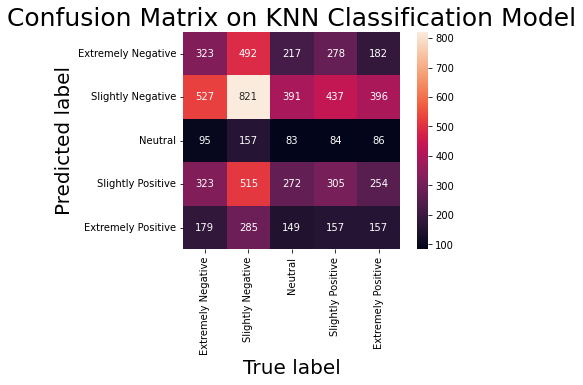

Training Accuracy:  0.3646451252704306
Training Accuracy CV:  0.36436597333606136
Test Accuracy:  0.3589672016748081
Test F1-score:  0.10565882715415424
Test Precision:  0.07179344033496163
Test Recall:  0.2


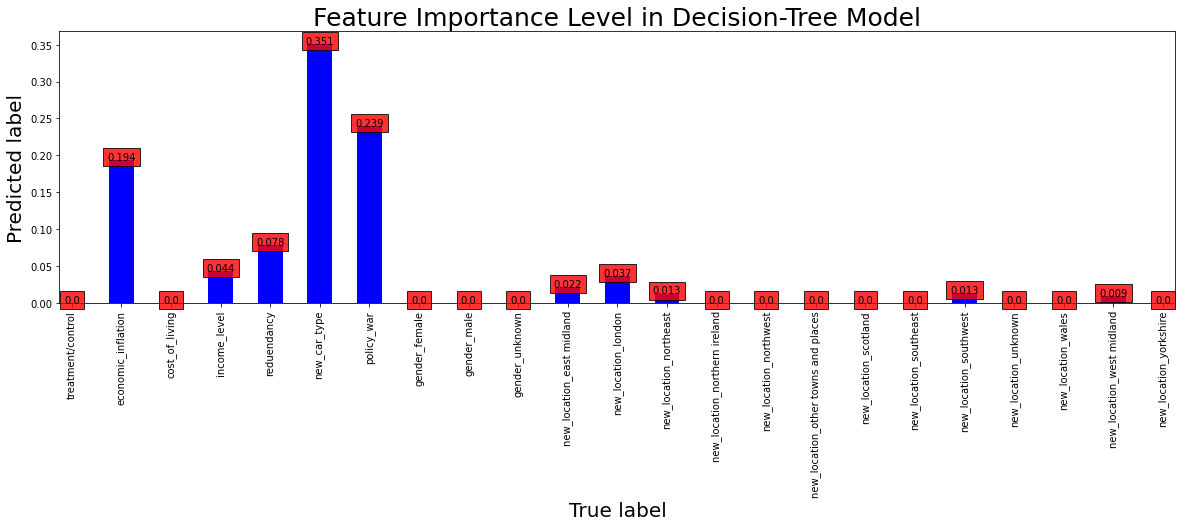

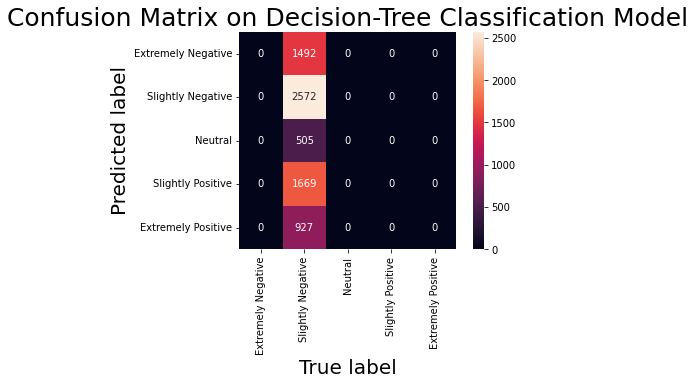

Training Accuracy:  0.3031614208946891
Training Accuracy CV:  0.2115642259432061
Test Accuracy:  0.2085136078157711
Test F1-score:  0.1946532038417277
Test Precision:  0.2213936656447481
Test Recall:  0.2304446139201029


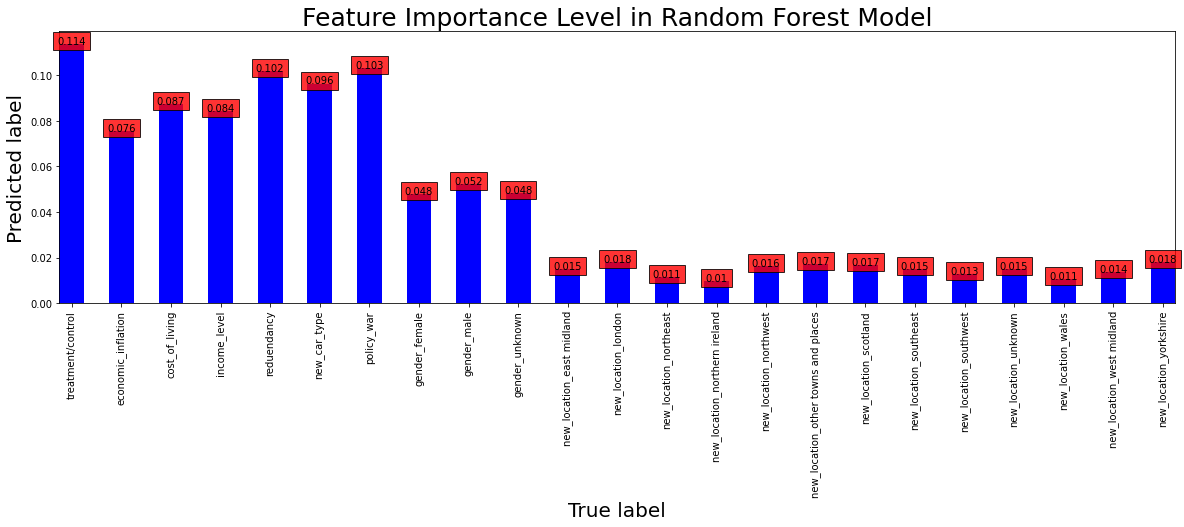

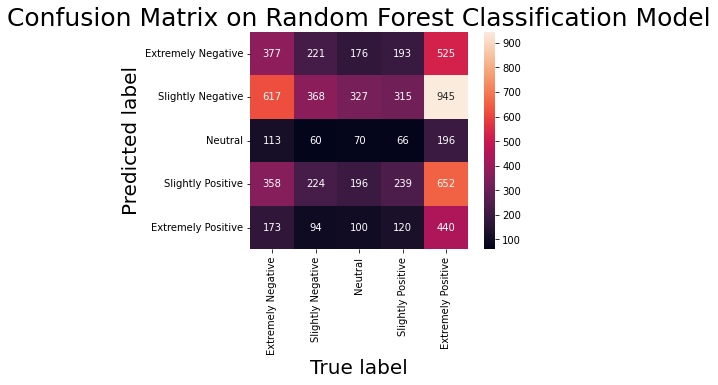

Training Accuracy:  0.3646451252704306
Training Accuracy CV:  0.3646451323758478
Test Accuracy:  0.3589672016748081
Test F1-score:  0.10565882715415424
Test Precision:  0.07179344033496163
Test Recall:  0.2


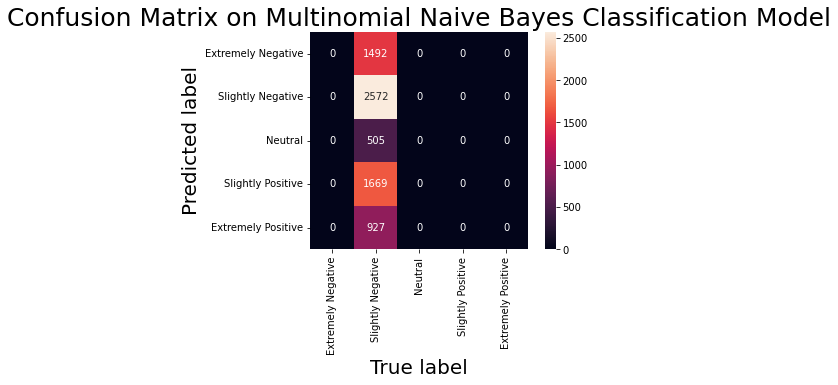

Training Accuracy:  0.35941098471630956
Training Accuracy CV:  0.36345860293822135
Test Accuracy:  0.3540823447313329
Test F1-score:  0.13199383115643692
Test Precision:  0.22295477690375187
Test Recall:  0.20389786134517723


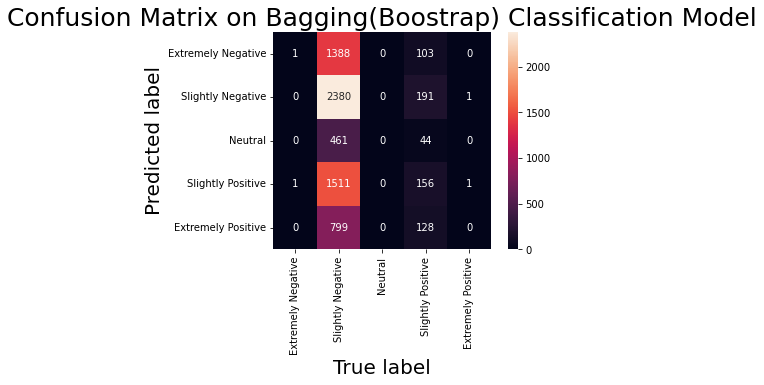

Training Accuracy:  0.3337636960011166
Training Accuracy CV:  0.32936695371747227
Test Accuracy:  0.32323796231681784
Test F1-score:  0.1869847980259527
Test Precision:  0.2065676658306083
Test Recall:  0.22047511914408938


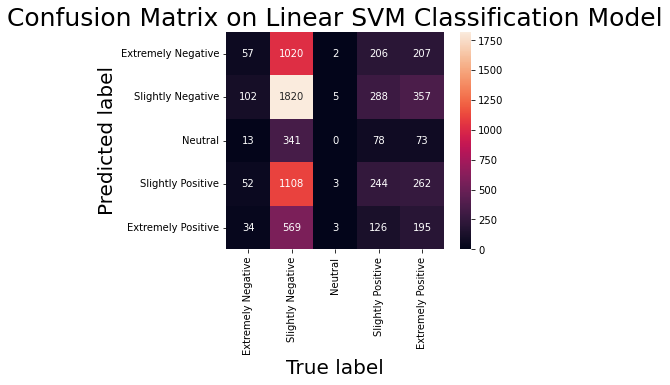

training loss =  1.433285117149353
training accuracy=  0.38073137402534485
90/90 [==============================] - 0s 775us/step - loss: 1.4614 - accuracy: 0.3857 - precision_167: 0.2621 - recall_167: 0.8422
training accuracy CV 10 =  0.36461037397384644
test loss =  1.5317184925079346
test accuracy=  0.34459176659584045
test precision=  0.2721887230873108
test recall=  0.7117934226989746
test f1_score:  0.3937919883120723
224/224 [==============================] - 0s 592us/step


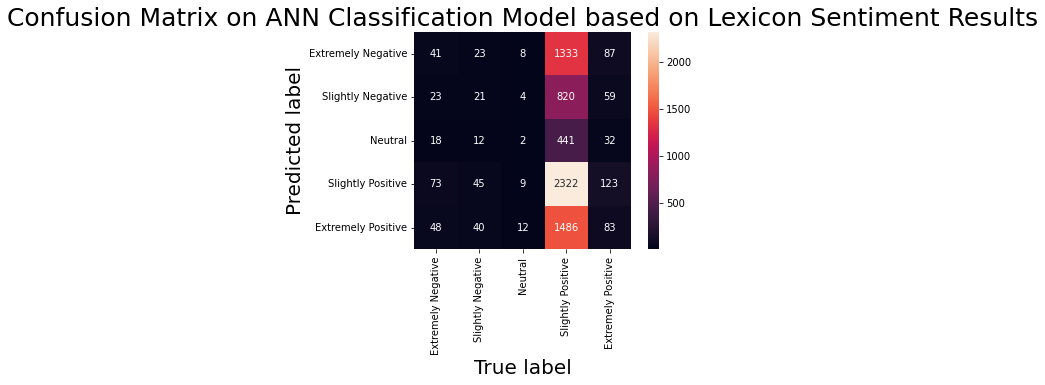

training loss =  1.4777859449386597
training accuracy=  0.3646451234817505
90/90 [==============================] - 1s 2ms/step - loss: 1.4685 - accuracy: 0.3857 - precision_178: 0.2699 - recall_178: 0.8098
training accuracy CV 10 =  0.36464526653289797
test loss =  1.4833712577819824
test accuracy=  0.35896721482276917
test precision=  0.2710762619972229
test recall=  0.7624563574790955
test f1_score:  0.3999560641369526
224/224 [==============================] - 1s 2ms/step


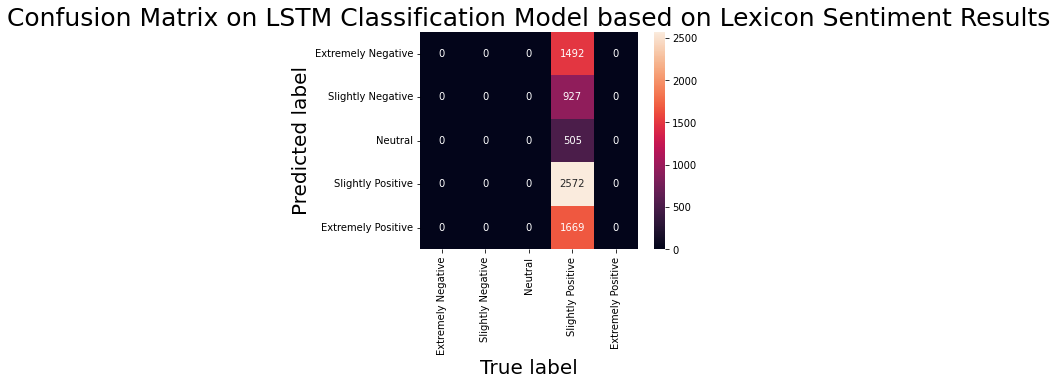

In [84]:
# Classification of Lexicon Sentiment Analysis
# KNN classification Model (Ball Tree)
neighour = KNeighborsClassifier(n_neighbors=1, algorithm='ball_tree', leaf_size=30, p=1, n_jobs=-1)
report(neighour,train_all_lexicon_X, test_all_lexicon_X, train_all_lexicon_y, test_all_lexicon_y)
heatmat(neighour,'Confusion Matrix on KNN Classification Model',test_all_lexicon_X, test_all_lexicon_y)
# Decision-Tree Model
decision_tree = DecisionTreeClassifier(criterion='entropy',max_depth=4, max_features='log2', random_state=100)
report(decision_tree,train_all_lexicon_X, test_all_lexicon_X, train_all_lexicon_y, test_all_lexicon_y)
feature_importance(decision_tree,'Feature Importance Level in Decision-Tree Model',test_all_lexicon_X)
heatmat(decision_tree,'Confusion Matrix on Decision-Tree Classification Model',test_all_lexicon_X, test_all_lexicon_y)
# Random Forest Classifier
random_forest = RandomForestClassifier(n_estimators=200, criterion='entropy', max_depth=10, max_features='log2', random_state=100, class_weight='balanced', n_jobs=-1)
report(random_forest,train_all_lexicon_X, test_all_lexicon_X, train_all_lexicon_y, test_all_lexicon_y)
feature_importance(random_forest,'Feature Importance Level in Random Forest Model',test_all_lexicon_X)
heatmat(random_forest,'Confusion Matrix on Random Forest Classification Model',test_all_lexicon_X, test_all_lexicon_y)
# Multinomial Naive Bayes Classifier
multinb = MultinomialNB(fit_prior=True)
report(multinb,train_all_lexicon_X, test_all_lexicon_X, train_all_lexicon_y, test_all_lexicon_y)
heatmat(multinb,'Confusion Matrix on Multinomial Naive Bayes Classification Model',test_all_lexicon_X, test_all_lexicon_y)
# Bagging Classifier
bagging = BaggingClassifier(base_estimator=SGDClassifier(loss='modified_huber', random_state=100, learning_rate='optimal', n_jobs=-1),n_estimators=19,random_state=100,n_jobs=-1)
report(bagging,train_all_lexicon_X, test_all_lexicon_X, train_all_lexicon_y, test_all_lexicon_y)
heatmat(bagging,'Confusion Matrix on Bagging(Boostrap) Classification Model',test_all_lexicon_X, test_all_lexicon_y)
#SVM Classifier
svm=LinearSVC(penalty='l2',class_weight='balanced',random_state=100)
report(svm,train_all_lexicon_X, test_all_lexicon_X, train_all_lexicon_y, test_all_lexicon_y)
heatmat(svm,'Confusion Matrix on Linear SVM Classification Model',test_all_lexicon_X, test_all_lexicon_y)

#ANN Classifier
#32 units is the best solution
def buildAnnModel():
    unit=32
    ann_model = Sequential([
    tf.keras.Input(shape=(len(train_mx_lexicon_X.columns),)),
    layers.Dense(unit,activation='PReLU'),
    layers.Dense(unit,activation='PReLU'),
    layers.Dense(unit,activation='PReLU'),
    layers.Dropout(0.20),
    layers.Dense(5,activation='sigmoid')
    ])
    ann_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy',keras.metrics.Precision(), keras.metrics.Recall()])
    return ann_model
ann_model = buildAnnModel()
ann_model.fit(train_mx_lexicon_X, train_mx_lexicon_y, epochs=100, batch_size=32,verbose=0, validation_split = 0.20)

score=loss, accuracy, precision, recall = ann_model.evaluate(train_mx_lexicon_X, train_mx_lexicon_y, verbose=0)
print('training loss = ',score[0])
print('training accuracy= ', score[1])

crossValidation=KerasClassifier(buildAnnModel)
score=cross_val_score(estimator=crossValidation, X=train_mx_lexicon_X, y=train_mx_lexicon_y, cv=10).mean()
print('training accuracy CV 10 = ',score)

score=loss, accuracy, precision, recall = ann_model.evaluate(test_mx_lexicon_X, test_mx_lexicon_y, verbose=0)
print('test loss = ',score[0])
print('test accuracy= ', score[1])
print('test precision= ',score[2])
print('test recall= ',score[3])
print('test f1_score: ',(2*score[2]*score[3])/(score[2]+score[3]))

ypred = np.argmax(ann_model.predict(test_mx_lexicon_X, verbose=1),axis=1)
labels=['Extremely Negative','Slightly Negative','Neutral','Slightly Positive','Extremely Positive']
confusion = confusion_matrix(np.argmax(test_mx_lexicon_y,axis=1),ypred)
sns.heatmap(confusion,square = True, annot=True, fmt ='d',xticklabels=labels, yticklabels=labels) 
plt.xlabel('True label',fontsize=20)
plt.ylabel('Predicted label',fontsize=20)
plt.title('Confusion Matrix on ANN Classification Model based on Lexicon Sentiment Results',fontsize=25)
plt.show()

# LSTM
def buildLstmModel():
    unit=32
    lstm_model = Sequential()
    lstm_model.add(Embedding(train_mx_lexicon_X.shape[0],train_mx_lexicon_X.shape[1]))
    lstm_model.add(LSTM(unit))
    lstm_model.add(Dropout(0.25))
    lstm_model.add(Dense(unit, activation='PReLU'))
    lstm_model.add(Dense(unit, activation='PReLU'))
    lstm_model.add(Dense(unit, activation='PReLU'))
    lstm_model.add(Dropout(0.20))
    lstm_model.add(Dense(5, activation='sigmoid'))
    lstm_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy',keras.metrics.Precision(), keras.metrics.Recall()])
    return lstm_model
lstm_model = buildLstmModel()
lstm_model.fit(train_mx_lexicon_X, train_mx_lexicon_y, epochs=100, batch_size=32,verbose=0, validation_split = 0.20)
score=loss, accuracy, precision, recall = lstm_model.evaluate(train_mx_lexicon_X, train_mx_lexicon_y, verbose=0)
print('training loss = ',score[0])
print('training accuracy= ', score[1])
crossValidation=KerasClassifier(buildLstmModel)
score=cross_val_score(estimator=crossValidation, X=train_mx_lexicon_X, y=train_mx_lexicon_y, cv=10).mean()
print('training accuracy CV 10 = ',score)
score=loss, accuracy, precision, recall = lstm_model.evaluate(test_mx_lexicon_X, test_mx_lexicon_y, verbose=0)
print('test loss = ',score[0])
print('test accuracy= ', score[1])
print('test precision= ',score[2])
print('test recall= ',score[3])
print('test f1_score: ',(2*score[2]*score[3])/(score[2]+score[3]))
ypred = np.argmax(lstm_model.predict(test_mx_lexicon_X, verbose=1),axis=1)
labels=['Extremely Negative','Slightly Negative','Neutral','Slightly Positive','Extremely Positive']
confusion = confusion_matrix(np.argmax(test_mx_lexicon_y,axis=1),ypred)
sns.heatmap(confusion,square = True, annot=True, fmt ='d',xticklabels=labels, yticklabels=labels) 
plt.xlabel('True label',fontsize=20)
plt.ylabel('Predicted label',fontsize=20)
plt.title('Confusion Matrix on LSTM Classification Model based on Lexicon Sentiment Results',fontsize=25)
plt.show()

In [ ]:
from sklearn.metrics import balanced_accuracy_score
balanced_accuracy_score()

Training Accuracy:  0.33861399958126875
Training Accuracy CV:  0.2694530689591759
Test Accuracy:  0.2665736217725052
Test F1-score:  0.20015577657459974
Test Precision:  0.20187395312094364
Test Recall:  0.2008372282969965


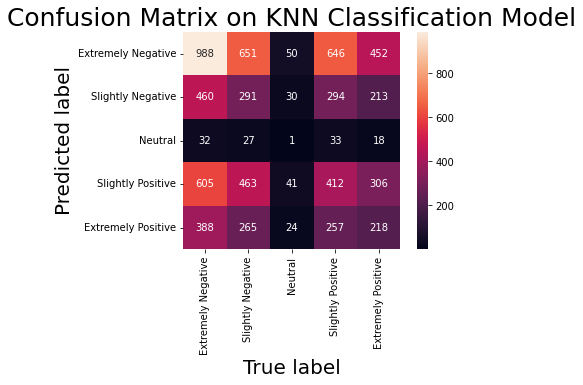

Training Accuracy:  0.3862097843534092
Training Accuracy CV:  0.3862097723931902
Test Accuracy:  0.3889741800418702
Test F1-score:  0.1120176848874598
Test Precision:  0.07779483600837403
Test Recall:  0.2


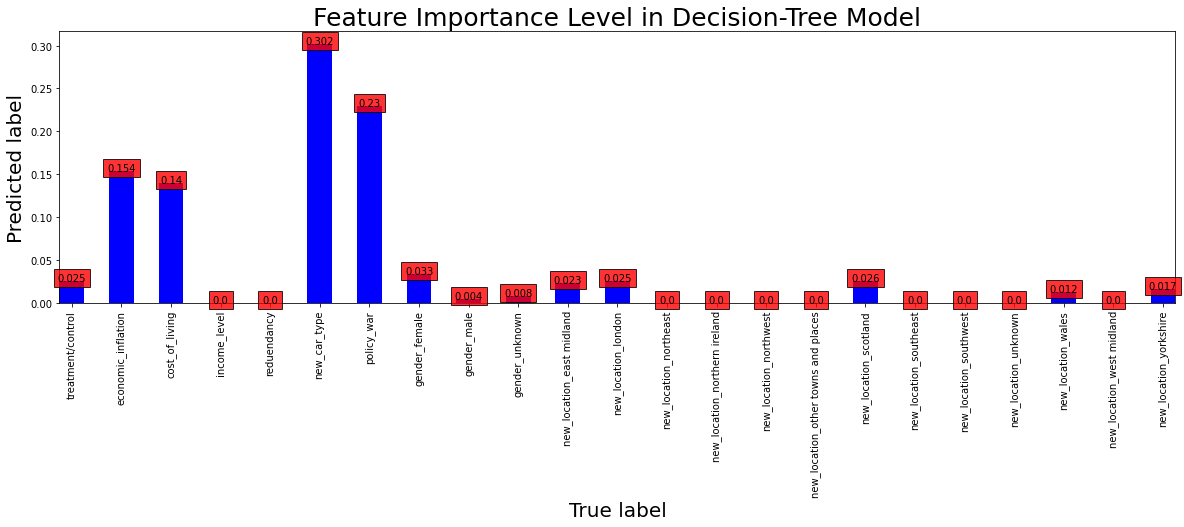

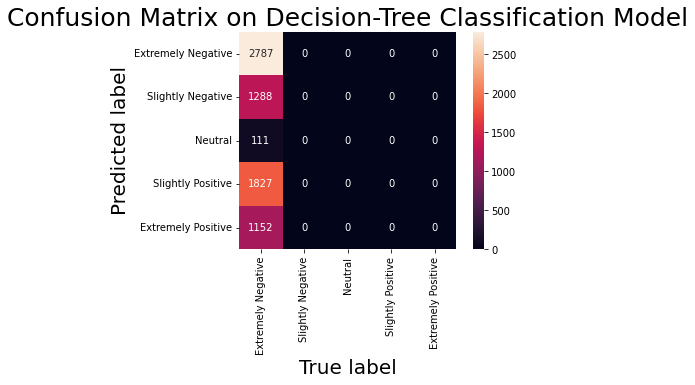

Training Accuracy:  0.29827622304417617
Training Accuracy CV:  0.21938042330555385
Test Accuracy:  0.20614096301465457
Test F1-score:  0.17668749858989113
Test Precision:  0.21293676667151856
Test Recall:  0.21395379979637363


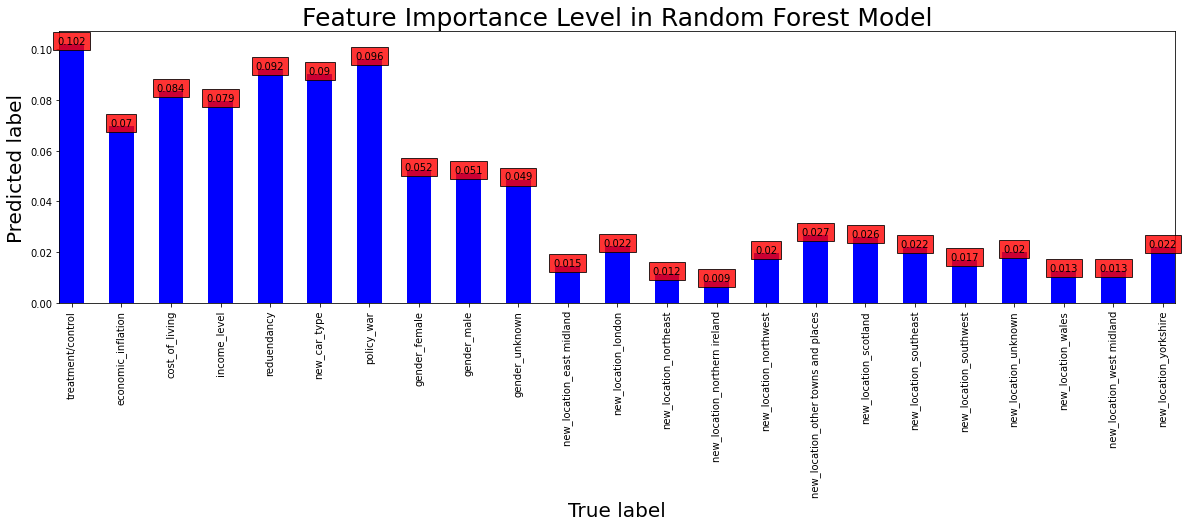

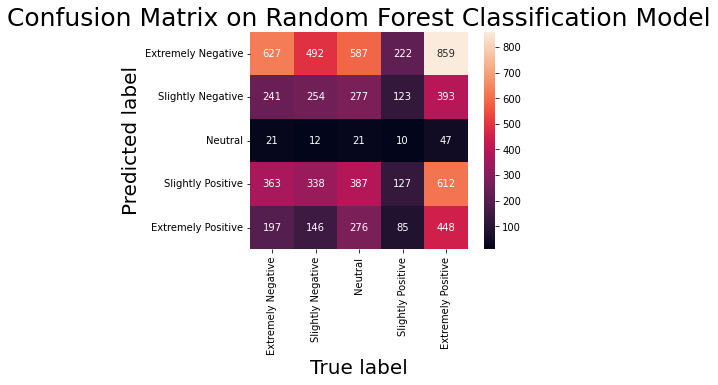

Training Accuracy:  0.3862097843534092
Training Accuracy CV:  0.3862097723931902
Test Accuracy:  0.3889741800418702
Test F1-score:  0.1120176848874598
Test Precision:  0.07779483600837403
Test Recall:  0.2


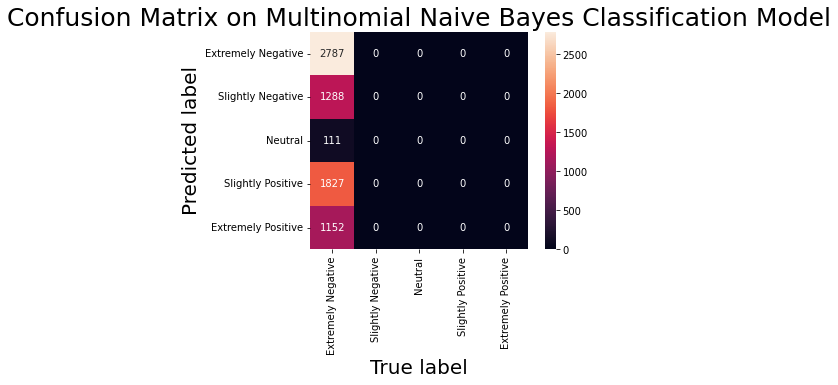

Training Accuracy:  0.32476097424802847
Training Accuracy CV:  0.32350502795609354
Test Accuracy:  0.3267271458478716
Test F1-score:  0.15775535653495548
Test Precision:  0.22068079913480573
Test Recall:  0.20021568260987976


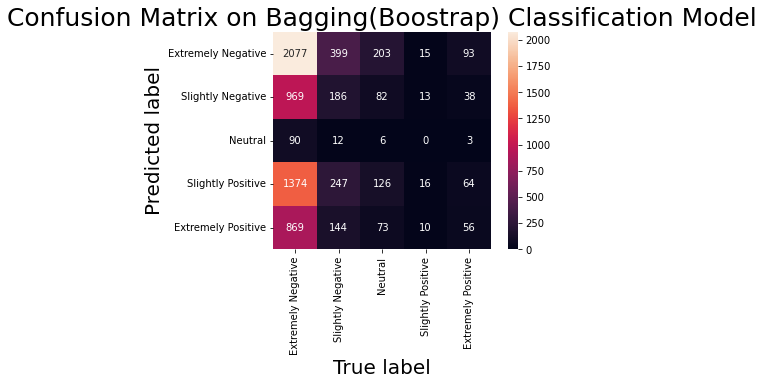

Training Accuracy:  0.34367366878358574
Training Accuracy CV:  0.34056790267796355
Test Accuracy:  0.3374738311235171
Test F1-score:  0.1990559593122235
Test Precision:  0.23208476030461508
Test Recall:  0.22049498601278722


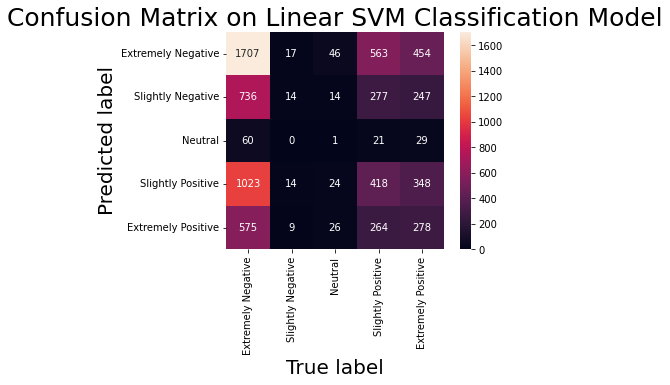

training loss =  1.3341306447982788
training accuracy=  0.40358713269233704
90/90 [==============================] - 0s 607us/step - loss: 1.3852 - accuracy: 0.3805 - precision_189: 0.2458 - recall_189: 0.9832
training accuracy CV 10 =  0.3862797528505325
test loss =  1.4364397525787354
test accuracy=  0.3709699809551239
test precision=  0.285941481590271
test recall=  0.7528262138366699
test f1_score:  0.414460796022303
224/224 [==============================] - 0s 520us/step


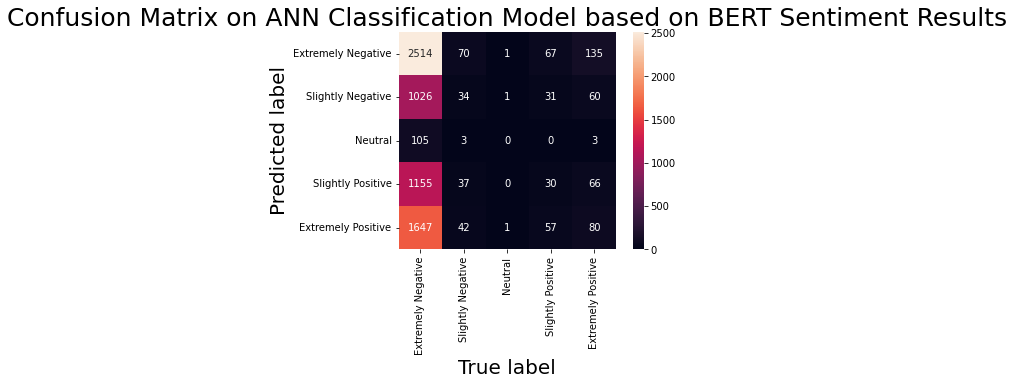

training loss =  1.386339545249939
training accuracy=  0.38620978593826294
90/90 [==============================] - 1s 2ms/step - loss: 1.3917 - accuracy: 0.3805 - precision_200: 0.2458 - recall_200: 0.9832
training accuracy CV 10 =  0.3862099677324295
test loss =  1.3832827806472778
test accuracy=  0.3889741897583008
test precision=  0.32198184728622437
test recall=  0.6439636945724487
test f1_score:  0.4293091297149658
224/224 [==============================] - 1s 2ms/step


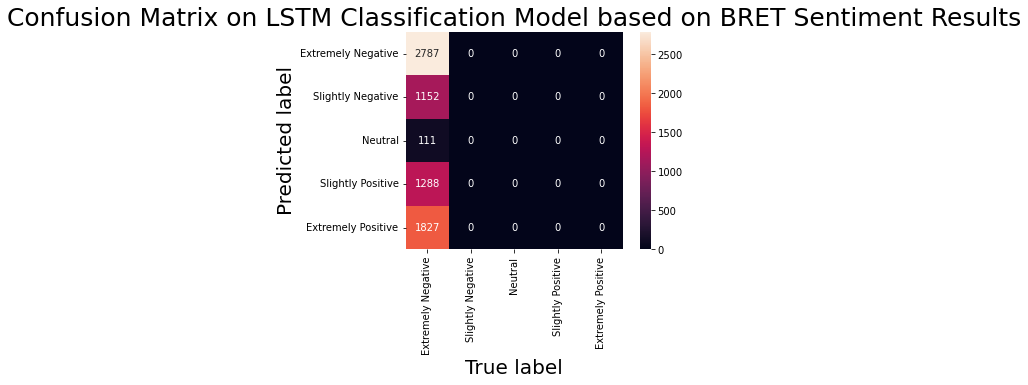

In [85]:
# Classification of Bert Sentiment Analysis
# KNN classification Model (Ball Tree)
neighour = KNeighborsClassifier(n_neighbors=1, algorithm='ball_tree', leaf_size=30, p=1, n_jobs=-1)
report(neighour,train_all_bert_X, test_all_bert_X, train_all_bert_y, test_all_bert_y)
heatmat(neighour,'Confusion Matrix on KNN Classification Model',test_all_bert_X, test_all_bert_y)
# Decision-Tree Model
decision_tree = DecisionTreeClassifier(criterion='entropy',max_depth=4, max_features='log2', random_state=100)
report(decision_tree,train_all_bert_X, test_all_bert_X, train_all_bert_y, test_all_bert_y)
feature_importance(decision_tree,'Feature Importance Level in Decision-Tree Model',test_all_bert_X)
heatmat(decision_tree,'Confusion Matrix on Decision-Tree Classification Model',test_all_bert_X, test_all_bert_y)
# Random Forest Classifier
random_forest = RandomForestClassifier(n_estimators=200, criterion='entropy', max_depth=10, max_features='log2', random_state=100, class_weight='balanced', n_jobs=-1)
report(random_forest,train_all_bert_X, test_all_bert_X, train_all_bert_y, test_all_bert_y)
feature_importance(random_forest,'Feature Importance Level in Random Forest Model',test_all_bert_X)
heatmat(random_forest,'Confusion Matrix on Random Forest Classification Model',test_all_bert_X, test_all_bert_y)
# Multinomial Naive Bayes Classifier
multinb = MultinomialNB(fit_prior=True)
report(multinb,train_all_bert_X, test_all_bert_X, train_all_bert_y, test_all_bert_y)
heatmat(multinb,'Confusion Matrix on Multinomial Naive Bayes Classification Model',test_all_bert_X, test_all_bert_y)
# Bagging Classifier
bagging = BaggingClassifier(base_estimator=SGDClassifier(loss='squared_hinge', random_state=100, learning_rate='optimal', n_jobs=-1),n_estimators=19,random_state=100,n_jobs=-1)
report(bagging,train_all_bert_X, test_all_bert_X, train_all_bert_y, test_all_bert_y)
heatmat(bagging,'Confusion Matrix on Bagging(Boostrap) Classification Model',test_all_bert_X, test_all_bert_y)
#SVM Classifier
svm=LinearSVC(penalty='l2',class_weight='balanced',random_state=100)
report(svm,train_all_bert_X, test_all_bert_X, train_all_bert_y, test_all_bert_y)
heatmat(svm,'Confusion Matrix on Linear SVM Classification Model',test_all_bert_X, test_all_bert_y)
#ANN Classifier
annmodel = buildAnnModel()
annmodel.fit(train_mx_bert_X, train_mx_bert_y, epochs=100, batch_size=32,verbose=0, validation_split = 0.20)

score=loss, accuracy, precision, recall = annmodel.evaluate(train_mx_bert_X, train_mx_bert_y, verbose=0)
print('training loss = ',score[0])
print('training accuracy= ', score[1])

crossValidationbert=KerasClassifier(buildAnnModel)
score=cross_val_score(estimator=crossValidationbert, X=train_mx_bert_X, y=train_mx_bert_y, cv=10).mean()
print('training accuracy CV 10 = ',score)

score=loss, accuracy, precision, recall = annmodel.evaluate(test_mx_bert_X, test_mx_bert_y, verbose=0)
print('test loss = ',score[0])
print('test accuracy= ', score[1])
print('test precision= ',score[2])
print('test recall= ',score[3])
print('test f1_score: ',(2*score[2]*score[3])/(score[2]+score[3]))

ypred = np.argmax(annmodel.predict(test_mx_bert_X, verbose=1),axis=1)
labels=['Extremely Negative','Slightly Negative','Neutral','Slightly Positive','Extremely Positive']
confusion = confusion_matrix(np.argmax(test_mx_bert_y,axis=1),ypred)
sns.heatmap(confusion,square = True, annot=True, fmt ='d',xticklabels=labels, yticklabels=labels) 
plt.xlabel('True label',fontsize=20)
plt.ylabel('Predicted label',fontsize=20)
plt.title('Confusion Matrix on ANN Classification Model based on BERT Sentiment Results',fontsize=25)
plt.show()

# LSTM
lstm_model = buildLstmModel()
lstm_model.fit(train_mx_bert_X, train_mx_bert_y, epochs=100, batch_size=32,verbose=0, validation_split = 0.20)
score=loss, accuracy, precision, recall = lstm_model.evaluate(train_mx_bert_X, train_mx_bert_y, verbose=0)
print('training loss = ',score[0])
print('training accuracy= ', score[1])
crossValidation=KerasClassifier(buildLstmModel)
score=cross_val_score(estimator=crossValidation, X=train_mx_bert_X, y=train_mx_bert_y, cv=10).mean()
print('training accuracy CV 10 = ',score)
score=loss, accuracy, precision, recall = lstm_model.evaluate(test_mx_bert_X, test_mx_bert_y, verbose=0)
print('test loss = ',score[0])
print('test accuracy= ', score[1])
print('test precision= ',score[2])
print('test recall= ',score[3])
print('test f1_score: ',(2*score[2]*score[3])/(score[2]+score[3]))
ypred = np.argmax(lstm_model.predict(test_mx_bert_X, verbose=1),axis=1)
labels=['Extremely Negative','Slightly Negative','Neutral','Slightly Positive','Extremely Positive']
confusion = confusion_matrix(np.argmax(test_mx_bert_y,axis=1),ypred)
sns.heatmap(confusion,square = True, annot=True, fmt ='d',xticklabels=labels, yticklabels=labels) 
plt.xlabel('True label',fontsize=20)
plt.ylabel('Predicted label',fontsize=20)
plt.title('Confusion Matrix on LSTM Classification Model based on BRET Sentiment Results',fontsize=25)
plt.show()